In [ ]:
!pip install gradio

#gestion manquantes supprimés avec gestion outliers par campement

In [1]:
# Librairies principales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time

# Machine Learning et prétraitement
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer

# Deep Learning
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Bidirectional, LSTM, GRU, SimpleRNN, Dense, Dropout

# XGBoost
from xgboost import XGBRegressor

# Interface utilisateur
#import gradio as gr

# Sauvegarde des modèles
import joblib


In [2]:
df=pd.read_csv("/content/df.csv")


#pretraitement

In [3]:
# Add a 'Month' column based on DOY for grouping
df['Date'] = pd.to_datetime(df['YEAR'] * 1000 + df['DOY'], format='%Y%j')
df['Month'] = df['Date'].dt.month
df_Month = df[['Month', 'T2M', 'T2MDEW', 'T2M_MAX', 'T2M_MIN',
               'PS', 'WS2M', 'PRECTOTCORR', 'GWETROOT', 'ALLSKY_SFC_SW_DWN', 'ALLSKY_SFC_LW_DWN']]

#créons la variable saison
def assign_season_by_month(month):
    if 5 <= month <= 10:
        return 'Saison_pluies'
    else:
        return 'Saison_seche'

# Appliquer la fonction pour créer la colonne 'Saison' en utilisant 'Month'
df['Saison'] = df['Month'].apply(assign_season_by_month)



# Vérifier et convertir la colonne Saison en type catégorie, si nécessaire
if df['Saison'].dtype != 'category':
    df['Saison'] = df['Saison'].astype('category')
# Apply one-hot encoding to the 'Saison' column with drop_first=False to keep all categories distinct
df = pd.get_dummies(df, columns=['Saison'], drop_first=False)


In [4]:

# Supprimer la colonne 'Date' car elle est de type datetime
df = df.drop(columns=['Date'])
# Convertir les colonnes booléennes en numériques si nécessaire
df['Saison_Saison_pluies'] = df['Saison_Saison_pluies'].astype(int)
df['Saison_Saison_seche'] = df['Saison_Saison_seche'].astype(int)

In [5]:
import numpy as np

# Define the IRR calculation function based on the provided code
def irr(df):
    # Variables
    T2M = df['T2M'].values
    T2MDEW = df['T2MDEW'].values
    T2M_MAX = df['T2M_MAX'].values
    T2M_MIN = df['T2M_MIN'].values
    Rns = df['ALLSKY_SFC_SW_DWN'].values
    Rnl = df['ALLSKY_SFC_LW_DWN'].values
    patm = df['PS'].values
    u2 = df['WS2M'].values
    P = df['PRECTOTCORR'].values  # Précipitations totales corrigées
    pourcentage_humidite_Sol = df['GWETROOT'].values

    # Set constant kc
    kc = 1

    # Calculations
    es = (0.6108 * np.exp((17.27 * T2M_MAX) / (T2M_MAX + 237.3)) +
          0.6108 * np.exp((17.27 * T2M_MIN) / (T2M_MIN + 237.3))) / 2
    ea = 0.6108 * np.exp((17.27 * T2MDEW) / (T2MDEW + 237.3))
    gamma = 0.665 * 10**-3 * patm
    Rn = Rnl - Rns  # Net radiation flux
    delta = (4098 * es) / (237.3 + T2M)**2
    ET0 = (0.408 * delta * Rn + gamma * (900 / (T2M + 273)) * u2 * (es - ea)) / (delta + gamma * (1 + 0.34 * u2))
    humidite_sol = ET0 * pourcentage_humidite_Sol
    IRR = ET0 - P - humidite_sol

    # Add IRR to the DataFrame
    df['IRR'] = IRR
    return df

# Apply the IRR calculation to the dataset
df = irr(df)




In [6]:

# Assurez-vous que df est trié par ordre chronologique
# df = df.sort_values(by='date_column')  # Si ce n'est pas déjà fait

# Fonction pour la méthode de campement
def apply_camping_method(data, lower_quantile=0.01, upper_quantile=0.99):
    """
    Applique la méthode de campement sur les données en limitant
    les valeurs aux quantiles spécifiés.
    """
    lower_bound = np.quantile(data, lower_quantile, axis=0)
    upper_bound = np.quantile(data, upper_quantile, axis=0)
    return np.clip(data, lower_bound, upper_bound)

# Normalisation des fonctionnalités uniquement
feature_scaler = MinMaxScaler()
df_features_scaled = feature_scaler.fit_transform(df.drop(columns=['IRR']))  # Supposons que 'IRR' est la colonne cible

# Normalisation de la cible uniquement
target_scaler = MinMaxScaler()
df_target_scaled = target_scaler.fit_transform(df[['IRR']])  # Notez le double crochet pour garder un DataFrame

# Conversion en DataFrame normalisé pour la cible et les features
df_scaled = pd.DataFrame(df_features_scaled, columns=df.drop(columns=['IRR']).columns)
df_scaled['IRR'] = df_target_scaled  # Ajout de la colonne cible normalisée

# Division Train, Validation (Test)
train_size = int(len(df_scaled) * 0.8)  # 80% pour l'entraînement
test = len(df_scaled) - train_size  # 20% pour validation (test)

# Division des données en train et test
train_data = df_scaled.iloc[:train_size]  # 80% des données pour l'entraînement
test_data = df_scaled.iloc[train_size:]   # 20% des données pour le test (validation)

############################################################################################
#a executer uniquement si on doit gerer les nan
######################################################################################
# Interpolation for train_data
train_data=train_data.interpolate(method='linear', limit_direction='forward', axis=0)

# supprimons les nan de lensemble test
test_data=test_data.dropna()
#################################################################################


# Préparation des fonctionnalités (features) et des cibles (target)
target_column = 'IRR'  # Nom de la colonne cible
X_train = train_data.drop(columns=[target_column])  # Features d'entraînement (DataFrame Pandas)
y_train = train_data[[target_column]]  # Cible d'entraînement (en DataFrame pour scaler)

X_test = test_data.drop(columns=[target_column])  # Features de test (DataFrame Pandas)
y_test = test_data[[target_column]]  # Cible de test (en DataFrame pour scaler)

# Appliquer la méthode de campement uniquement sur les données d'entraînement
X_train = apply_camping_method(X_train, lower_quantile=0.01, upper_quantile=0.99)
y_train = apply_camping_method(y_train, lower_quantile=0.01, upper_quantile=0.99)

# Reshape explicite pour les données d'entraînement
X_train = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
y_train = y_train.values.reshape(-1, 1)  # y_train en 2D si nécessaire

# Reshape explicite pour les données de test
X_test = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)
y_test = y_test.values.reshape(-1, 1)  # y_test en 2D si nécessaire


In [7]:
# Afficher les dimensions (lignes et colonnes) des DataFrames
print(f"Original DataFrame dimensions: {df.shape}")  # Dimensions de df
print(f"Train Data dimensions: {train_data.shape}")  # Dimensions des données d'entraînement
print(f"Test Data dimensions: {test_data.shape}")    # Dimensions des données de test

print(f"X_train dimensions: {X_train.shape}")  # Dimensions des features d'entraînement
print(f"y_train dimensions: {y_train.shape}")  # Dimensions de la cible d'entraînement

print(f"X_test dimensions: {X_test.shape}")    # Dimensions des features de test
print(f"y_test dimensions: {y_test.shape}")    # Dimensions de la cible de test")

# Afficher les 3 premières lignes des DataFrames
print("\nFirst 3 rows of the original DataFrame:")
print(df.head(3))  # Premières lignes de df

print("\nFirst 3 rows of the train DataFrame:")
print(train_data.head(3))  # Premières lignes des données d'entraînement

print("\nFirst 3 rows of the test DataFrame:")
print(test_data.head(3))  # Premières lignes des données de test

print("\nFirst 3 rows of X_train:")
print(X_train[:3])  # Premières lignes des features d'entraînement (numpy array)

print("\nFirst 3 rows of y_train:")
print(y_train[:3])  # Premières lignes de la cible d'entraînement (numpy array)

print("\nFirst 3 rows of X_test:")
print(X_test[:3])  # Premières lignes des features de test (numpy array)

print("\nFirst 3 rows of y_test:")
print(y_test[:3])  # Premières lignes de la cible de test (numpy array)


Original DataFrame dimensions: (55520, 18)
Train Data dimensions: (44416, 18)
Test Data dimensions: (8192, 18)
X_train dimensions: (44416, 17, 1)
y_train dimensions: (44416, 1)
X_test dimensions: (8192, 17, 1)
y_test dimensions: (8192, 1)

First 3 rows of the original DataFrame:
     LAT    LON  YEAR  DOY    T2M  T2MDEW  T2M_MAX  T2M_MIN  \
0  10.25 -13.25  2020    1  24.87   11.90    33.43    17.74   
1  10.25 -12.75  2020    1  24.53    8.15    34.17    16.60   
2  10.25 -12.25  2020    1  23.35    6.59    33.13    15.52   

   ALLSKY_SFC_SW_DWN  ALLSKY_SFC_LW_DWN     PS  WS2M  PRECTOTCORR  GWETROOT  \
0              20.67             360.43  98.03  1.61          0.0      0.53   
1              21.14             327.40  97.20  1.98          0.0      0.54   
2              21.14             327.40  96.19  2.45          0.0      0.54   

   Month  Saison_Saison_pluies  Saison_Saison_seche        IRR  
0      1                     0                    1  45.329149  
1      1            

In [8]:
import joblib

# Sauvegarder les scalers
joblib.dump(feature_scaler, 'feature_scaler.pkl')
joblib.dump(target_scaler, 'target_scaler.pkl')

print("Feature scaler saved as 'feature_scaler.pkl'")
print("Target scaler saved as 'target_scaler.pkl'")


Feature scaler saved as 'feature_scaler.pkl'
Target scaler saved as 'target_scaler.pkl'


#Lstm

In [10]:
!pip install optuna

In [11]:
import optuna
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from time import time
import joblib
import tensorflow as tf

# Charger le scaler
target_scaler = joblib.load('target_scaler.pkl')

# Configuration de TimeSeriesSplit
n_splits = 5  # Réduit pour accélérer les essais
tscv = TimeSeriesSplit(n_splits=n_splits)

# Fonction objectif pour Optuna
def objective(trial):
    # Définir l’espace de recherche pour les hyperparamètres
    n_units = trial.suggest_int('n_units', 50, 150, step=50)  # 50 à 150 neurones par pas de 50
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.3, step=0.1)  # Dropout entre 0.1 et 0.3
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.01, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64])  # Choix de 32 ou 64

    mse_scores = []

    # Validation croisée
    for train_idx, val_idx in tscv.split(X_train):
        X_train_split, X_val_split = X_train[train_idx], X_train[val_idx]
        y_train_split, y_val_split = y_train[train_idx], y_train[val_idx]

        # Construire le modèle
        model = Sequential([
            Input(shape=(X_train_split.shape[1], X_train_split.shape[2])),
            LSTM(n_units, activation='relu', return_sequences=True),
            Dropout(dropout_rate),
            LSTM(n_units, activation='relu'),
            Dropout(dropout_rate),
            Dense(1)
        ])

        # Compiler le modèle
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss='mse')

        # Entraîner le modèle
        history = model.fit(X_train_split, y_train_split,
                            epochs=10,  # Réduction des époques pour accélérer les essais
                            batch_size=batch_size,
                            validation_data=(X_val_split, y_val_split),
                            verbose=0)

        # Prédictions et calcul des métriques
        y_val_pred = model.predict(X_val_split)
        y_val_pred_original = target_scaler.inverse_transform(y_val_pred)
        y_val_original = target_scaler.inverse_transform(y_val_split)

        mse = mean_squared_error(y_val_original, y_val_pred_original)
        mse_scores.append(mse)

    # Retourne la moyenne des MSE (objectif à minimiser)
    return np.mean(mse_scores)

# Étudier avec Optuna
study = optuna.create_study(direction='minimize')  # Minimiser le MSE
study.optimize(objective, n_trials=5)  # Limité à 10 essais pour l'exemple

# Résultats finaux
print("\nBest Parameters:")
print(study.best_params)
print(f"Best MSE: {study.best_value}")

# Sauvegarde des résultats
study.trials_dataframe().to_csv('optuna_results.csv', index=False)


[I 2024-12-13 01:23:00,892] A new study created in memory with name: no-name-47d2382f-ef24-447f-bc0d-52cb99a324aa
<ipython-input-11-0c4ff9a8f265>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)  # Learning rate log-uniforme


232/232 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
232/232 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


[I 2024-12-13 01:25:53,098] Trial 0 finished with value: 220.34372664949584 and parameters: {'n_units': 50, 'dropout_rate': 0.3, 'learning_rate': 0.004447132433598301, 'batch_size': 64}. Best is trial 0 with value: 220.34372664949584.
<ipython-input-11-0c4ff9a8f265>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)  # Learning rate log-uniforme


232/232 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
232/232 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


[I 2024-12-13 01:31:11,426] Trial 1 finished with value: 155.64110132215555 and parameters: {'n_units': 100, 'dropout_rate': 0.2, 'learning_rate': 0.0028231921923301696, 'batch_size': 32}. Best is trial 1 with value: 155.64110132215555.
<ipython-input-11-0c4ff9a8f265>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)  # Learning rate log-uniforme


232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
232/232 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
232/232 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


[I 2024-12-13 01:34:17,231] Trial 2 finished with value: 258.4146127007287 and parameters: {'n_units': 100, 'dropout_rate': 0.3, 'learning_rate': 0.007447137447535433, 'batch_size': 64}. Best is trial 1 with value: 155.64110132215555.
<ipython-input-11-0c4ff9a8f265>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)  # Learning rate log-uniforme


232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
232/232 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


[I 2024-12-13 01:39:01,138] Trial 3 finished with value: 184.4355242568231 and parameters: {'n_units': 50, 'dropout_rate': 0.1, 'learning_rate': 0.0014836994817411678, 'batch_size': 32}. Best is trial 1 with value: 155.64110132215555.
<ipython-input-11-0c4ff9a8f265>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.01)  # Learning rate log-uniforme


232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
232/232 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
232/232 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


[I 2024-12-13 01:42:09,409] Trial 4 finished with value: 161.3471281154645 and parameters: {'n_units': 50, 'dropout_rate': 0.2, 'learning_rate': 0.003249145048198646, 'batch_size': 64}. Best is trial 1 with value: 155.64110132215555.



Best Parameters:
{'n_units': 100, 'dropout_rate': 0.2, 'learning_rate': 0.0028231921923301696, 'batch_size': 32}
Best MSE: 155.64110132215555



Processing Split 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Split 0 Time: 0 min 36 sec
Split Metrics - MSE: 203.2326866275178, MAE: 10.794607252934835, RMSE: 14.255970209968797, R²: 0.749775630617813

Processing Split 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Split 0 Time: 0 min 48 sec
Split Metrics - MSE: 307.1251504161564, MAE: 11.372881329337991, RMSE: 17.524986459799518, R²: 0.7803303053151137

Processing Split 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Split 0 Time: 0 min 56 sec
Split Metrics - MSE: 56.16785776471465, MAE: 5.945817348789723, RMSE: 7.494521850306039, R²: 0.8658313418233052

Processing Split 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Split 0 Time: 1 min 25 sec
Split Metrics - MSE: 184.537135433021, MAE: 10.32253697405723, RMSE: 13.58444461260824, R²: 0.734751795612887

Processing Split 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Split 0 Time: 1 min 32 sec
Split Metrics - MSE: 52.08792759086136, MAE: 5.366612577864938, RMSE: 7.217196657349817, R²: 0.9247458506880696

Cross-Validation Metrics (Original Scale):
Average MSE: 160.63015156645423
Average MAE: 8.760491096596942
Average RMSE: 12.015423958006481
Average R²: 0.8110869848114378

Total Validation Time: 5 min 20 sec

Testing on the Test Set...
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Test Time: 0 min 1 sec

Test Set Metrics (Original Scale):
MSE: 122.00186177766253
MAE: 6.0151290580463845
RMSE: 11.045445295580551
R²: 0.8677742649008734


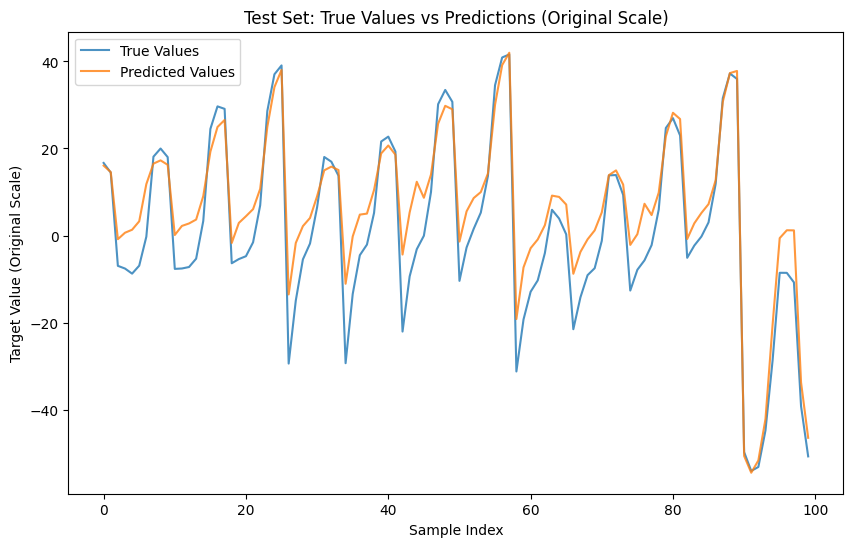

In [ ]:

# Charger les scalers pour normalisation et re-inverse
target_scaler = joblib.load('target_scaler.pkl')  # Scaler utilisé pour la cible

# Configuration de TimeSeriesSplit
n_splits = 5  # Nombre de divisions pour la validation croisée
tscv = TimeSeriesSplit(n_splits=n_splits)

# Liste pour stocker les scores des métriques
mse_scores = []
mae_scores = []
r2_scores = []
rmse_scores = []

# Liste pour les temps d'exécution
validation_times = []

# Parcours des splits de la validation croisée
split_num = 1
for train_idx, val_idx in tscv.split(X_train):
    print(f"\nProcessing Split {split_num}/{n_splits}")
    split_start = time()  # Démarrer le chronomètre pour ce split

    # Division des données en train et validation pour ce split
    X_train_split, X_val_split = X_train[train_idx], X_train[val_idx]
    y_train_split, y_val_split = y_train[train_idx], y_train[val_idx]

        # Définition du modèle LSTM simple
    model = Sequential()
    model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(X_train_split.shape[1], X_train_split.shape[2])))
    model.add(Dropout(0.2))  # Régularisation
    model.add(LSTM(100, activation='relu'))
    model.add(Dropout(0.2))  # Régularisation
    model.add(Dense(1))  # Couche de sortie pour la régression


    # Compilation du modèle
    model.compile(optimizer='adam', loss='mse')

    # Entraînement du modèle
    history = model.fit(X_train_split, y_train_split,
                        epochs=20,
                        batch_size=64,
                        validation_data=(X_val_split, y_val_split),
                        verbose=0)

    # Prédictions sur le jeu de validation
    y_val_pred = model.predict(X_val_split)

    # Re-inverse pour ramener les prédictions et les valeurs réelles à l'échelle d'origine
    y_val_pred_original = target_scaler.inverse_transform(y_val_pred)
    y_val_original = target_scaler.inverse_transform(y_val_split)

    # Calcul des métriques sur l'échelle originale
    mse = mean_squared_error(y_val_original, y_val_pred_original)
    mae = mean_absolute_error(y_val_original, y_val_pred_original)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val_original, y_val_pred_original)

    # Stockage des scores
    mse_scores.append(mse)
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    r2_scores.append(r2)

    # Calcul du temps d'exécution pour ce split
    split_time = time() - split_start
    validation_times.append(split_time)
    print(f"Split {split_num - 1} Time: {int(split_time // 60)} min {int(split_time % 60)} sec")
    print(f"Split Metrics - MSE: {mse}, MAE: {mae}, RMSE: {rmse}, R²: {r2}")

# Moyennes des métriques sur tous les splits
print("\nCross-Validation Metrics (Original Scale):")
print(f"Average MSE: {np.mean(mse_scores)}")
print(f"Average MAE: {np.mean(mae_scores)}")
print(f"Average RMSE: {np.mean(rmse_scores)}")
print(f"Average R²: {np.mean(r2_scores)}")

# Temps total pour la validation croisée
total_validation_time = sum(validation_times)
print(f"\nTotal Validation Time: {int(total_validation_time // 60)} min {int(total_validation_time % 60)} sec")

model.save('lstm5-1.keras')


# Évaluation finale sur le jeu de test
print("\nTesting on the Test Set...")
test_start = time()  # Démarrer le chronomètre pour le test


# Prédictions sur le jeu de test
y_test_pred = model.predict(X_test)

# Re-inverse pour ramener les prédictions et les valeurs réelles à l'échelle d'origine
y_test_pred_original = target_scaler.inverse_transform(y_test_pred)
y_test_original = target_scaler.inverse_transform(y_test)

# Calcul des métriques sur l'échelle originale
mse_test = mean_squared_error(y_test_original, y_test_pred_original)
mae_test = mean_absolute_error(y_test_original, y_test_pred_original)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test_original, y_test_pred_original)

# Calcul du temps d'exécution pour le test
test_time = time() - test_start
print(f"\nTest Time: {int(test_time // 60)} min {int(test_time % 60)} sec")

# Affichage des métriques sur le jeu de test
print("\nTest Set Metrics (Original Scale):")
print(f"MSE: {mse_test}")
print(f"MAE: {mae_test}")
print(f"RMSE: {rmse_test}")
print(f"R²: {r2_test}")

# Visualisation des résultats sur le jeu de test
plt.figure(figsize=(10, 6))
plt.plot(y_test_original[:100], label="True Values", alpha=0.8)  # Afficher les 100 premières valeurs pour la lisibilité
plt.plot(y_test_pred_original[:100], label="Predicted Values", alpha=0.8)
plt.title("Test Set: True Values vs Predictions (Original Scale)")
plt.xlabel("Sample Index")
plt.ylabel("Target Value (Original Scale)")
plt.legend()
plt.show()



Processing Split 1/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Split 0 Time: 0 min 28 sec
Split Metrics - MSE: 1028.9440634943296, MAE: 25.50316596138913, RMSE: 32.07715797096634, R²: -1.1152402389709244

Processing Split 1/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Split 0 Time: 0 min 37 sec
Split Metrics - MSE: 208.42040102361182, MAE: 12.140511093078228, RMSE: 14.436772527944457, R²: -1.7400952745451934

Processing Split 1/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Split 0 Time: 0 min 50 sec
Split Metrics - MSE: 319.3646207404088, MAE: 11.17450733401921, RMSE: 17.870775605451733, R²: 0.6903174905896907

Processing Split 1/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Split 0 Time: 1 min 2 sec
Split Metrics - MSE: 56.64931993640778, MAE: 5.742813216243824, RMSE: 7.526574249710673, R²: 0.864597699768408

Processing Split 1/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Split 0 Time: 1 min 11 sec
Split Metrics - MSE: 142.27610398896562, MAE: 11.4023501656735, RMSE: 11.927954727821765, R²: 0.8790337932695615

Processing Split 1/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Split 0 Time: 1 min 27 sec
Split Metrics - MSE: 33.75723724917625, MAE: 4.582433207590382, RMSE: 5.8100978691564436, R²: 0.9403739833948007

Processing Split 1/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Split 0 Time: 1 min 39 sec
Split Metrics - MSE: 9.51349466296727, MAE: 2.422682251190428, RMSE: 3.084395348032945, R²: 0.9884899666905886

Cross-Validation Metrics (Original Scale):
Average MSE: 256.9893201565525
Average MAE: 10.424066175597815
Average RMSE: 13.247675471297764
Average R²: 0.2153539171709903

Total Validation Time: 7 min 18 sec

Testing on the Test Set...
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Test Time: 0 min 1 sec

Test Set Metrics (Original Scale):
MSE: 73.63036567543519
MAE: 2.8893202290886832
RMSE: 8.580813811954854
R²: 0.9201993388855443


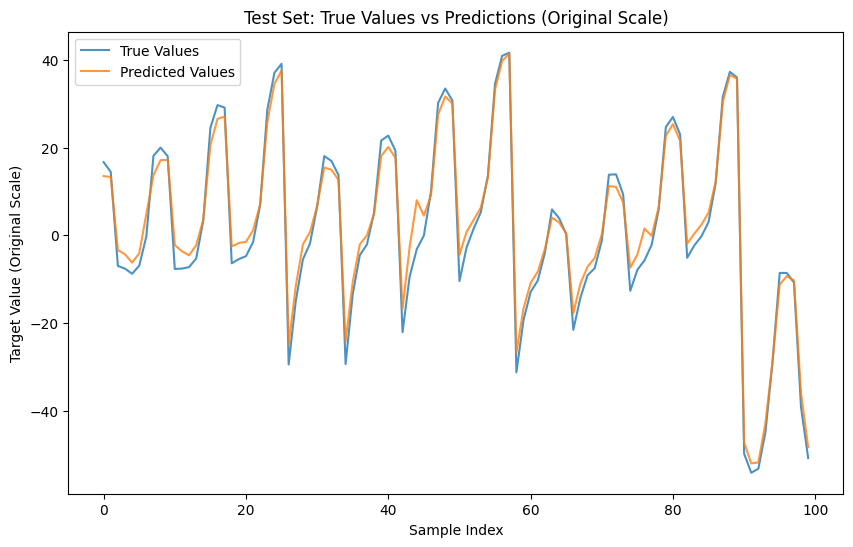

In [ ]:

# Charger les scalers pour normalisation et re-inverse
target_scaler = joblib.load('target_scaler.pkl')  # Scaler utilisé pour la cible

# Configuration de TimeSeriesSplit
n_splits = 7  # Nombre de divisions pour la validation croisée
tscv = TimeSeriesSplit(n_splits=n_splits)

# Liste pour stocker les scores des métriques
mse_scores = []
mae_scores = []
r2_scores = []
rmse_scores = []

# Liste pour les temps d'exécution
validation_times = []

# Parcours des splits de la validation croisée
split_num = 1
for train_idx, val_idx in tscv.split(X_train):
    print(f"\nProcessing Split {split_num}/{n_splits}")
    split_start = time()  # Démarrer le chronomètre pour ce split

    # Division des données en train et validation pour ce split
    X_train_split, X_val_split = X_train[train_idx], X_train[val_idx]
    y_train_split, y_val_split = y_train[train_idx], y_train[val_idx]

        # Définition du modèle LSTM simple
    model = Sequential()
    model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(X_train_split.shape[1], X_train_split.shape[2])))
    model.add(Dropout(0.2))  # Régularisation
    model.add(LSTM(100, activation='relu'))
    model.add(Dropout(0.2))  # Régularisation
    model.add(Dense(1))  # Couche de sortie pour la régression


    # Compilation du modèle
    model.compile(optimizer='adam', loss='mse')

    # Entraînement du modèle
    history = model.fit(X_train_split, y_train_split,
                        epochs=20,
                        batch_size=64,
                        validation_data=(X_val_split, y_val_split),
                        verbose=0)

    # Prédictions sur le jeu de validation
    y_val_pred = model.predict(X_val_split)

    # Re-inverse pour ramener les prédictions et les valeurs réelles à l'échelle d'origine
    y_val_pred_original = target_scaler.inverse_transform(y_val_pred)
    y_val_original = target_scaler.inverse_transform(y_val_split)

    # Calcul des métriques sur l'échelle originale
    mse = mean_squared_error(y_val_original, y_val_pred_original)
    mae = mean_absolute_error(y_val_original, y_val_pred_original)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val_original, y_val_pred_original)

    # Stockage des scores
    mse_scores.append(mse)
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    r2_scores.append(r2)

    # Calcul du temps d'exécution pour ce split
    split_time = time() - split_start
    validation_times.append(split_time)
    print(f"Split {split_num - 1} Time: {int(split_time // 60)} min {int(split_time % 60)} sec")
    print(f"Split Metrics - MSE: {mse}, MAE: {mae}, RMSE: {rmse}, R²: {r2}")

# Moyennes des métriques sur tous les splits
print("\nCross-Validation Metrics (Original Scale):")
print(f"Average MSE: {np.mean(mse_scores)}")
print(f"Average MAE: {np.mean(mae_scores)}")
print(f"Average RMSE: {np.mean(rmse_scores)}")
print(f"Average R²: {np.mean(r2_scores)}")

# Temps total pour la validation croisée
total_validation_time = sum(validation_times)
print(f"\nTotal Validation Time: {int(total_validation_time // 60)} min {int(total_validation_time % 60)} sec")

model.save('lstm7-1.keras')


# Évaluation finale sur le jeu de test
print("\nTesting on the Test Set...")
test_start = time()  # Démarrer le chronomètre pour le test


# Prédictions sur le jeu de test
y_test_pred = model.predict(X_test)

# Re-inverse pour ramener les prédictions et les valeurs réelles à l'échelle d'origine
y_test_pred_original = target_scaler.inverse_transform(y_test_pred)
y_test_original = target_scaler.inverse_transform(y_test)

# Calcul des métriques sur l'échelle originale
mse_test = mean_squared_error(y_test_original, y_test_pred_original)
mae_test = mean_absolute_error(y_test_original, y_test_pred_original)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test_original, y_test_pred_original)

# Calcul du temps d'exécution pour le test
test_time = time() - test_start
print(f"\nTest Time: {int(test_time // 60)} min {int(test_time % 60)} sec")

# Affichage des métriques sur le jeu de test
print("\nTest Set Metrics (Original Scale):")
print(f"MSE: {mse_test}")
print(f"MAE: {mae_test}")
print(f"RMSE: {rmse_test}")
print(f"R²: {r2_test}")

# Visualisation des résultats sur le jeu de test
plt.figure(figsize=(10, 6))
plt.plot(y_test_original[:100], label="True Values", alpha=0.8)  # Afficher les 100 premières valeurs pour la lisibilité
plt.plot(y_test_pred_original[:100], label="Predicted Values", alpha=0.8)
plt.title("Test Set: True Values vs Predictions (Original Scale)")
plt.xlabel("Sample Index")
plt.ylabel("Target Value (Original Scale)")
plt.legend()
plt.show()



Processing Split 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Split 0 Time: 0 min 24 sec
Split Metrics - MSE: 3925.620023246564, MAE: 55.473637034764025, RMSE: 62.65476855951639, R²: -4.022243827178536

Processing Split 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Split 0 Time: 0 min 28 sec
Split Metrics - MSE: 219.66954186763974, MAE: 11.028143282303526, RMSE: 14.82125304647484, R²: 0.6267699311840724

Processing Split 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Split 0 Time: 0 min 34 sec
Split Metrics - MSE: 56.748079105083356, MAE: 5.556333160753999, RMSE: 7.533132091307264, R²: -0.18442776096801206

Processing Split 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Split 0 Time: 0 min 49 sec
Split Metrics - MSE: 392.417623727876, MAE: 13.761172503199742, RMSE: 19.80953365750633, R²: 0.7295721015434253

Processing Split 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Split 0 Time: 0 min 51 sec
Split Metrics - MSE: 136.29745708899918, MAE: 8.120095594811314, RMSE: 11.674650191290494, R²: 0.6381340642883273

Processing Split 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Split 0 Time: 0 min 57 sec
Split Metrics - MSE: 28.330767754832113, MAE: 4.212777151086116, RMSE: 5.3226654746313065, R²: 0.7472880387311318

Processing Split 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
Split 0 Time: 1 min 5 sec
Split Metrics - MSE: 157.79178013404763, MAE: 9.63430581270853, RMSE: 12.561519817842411, R²: 0.8074694370126154

Processing Split 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Split 0 Time: 1 min 26 sec
Split Metrics - MSE: 281.7655293735479, MAE: 14.279646202582938, RMSE: 16.78587291068141, R²: 0.38333875458915845

Processing Split 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Split 0 Time: 1 min 38 sec
Split Metrics - MSE: 17.482307417270622, MAE: 3.2734773004944135, RMSE: 4.181184929810044, R²: 0.8482535873533237

Processing Split 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Split 0 Time: 1 min 32 sec
Split Metrics - MSE: 32.19102435479631, MAE: 4.396032510737539, RMSE: 5.673713453708807, R²: 0.9586577975457111

Cross-Validation Metrics (Original Scale):
Average MSE: 524.8314134070657
Average MAE: 12.973562055344214
Average RMSE: 16.101829413276935
Average R²: 0.15328121241012177

Total Validation Time: 9 min 50 sec

Testing on the Test Set...
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Test Time: 0 min 2 sec

Test Set Metrics (Original Scale):
MSE: 94.27235430545342
MAE: 4.3681358355959095
RMSE: 9.709395156519967
R²: 0.8978275317611082


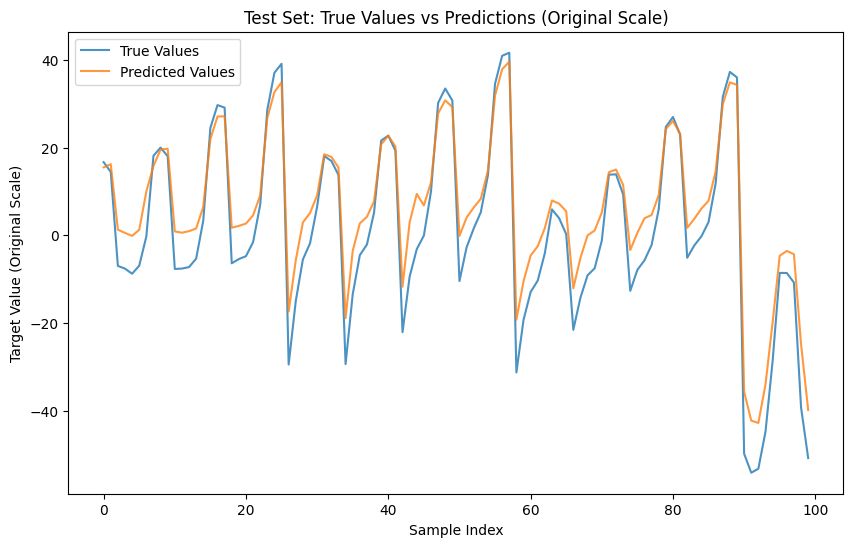

In [ ]:


# Charger les scalers pour normalisation et re-inverse
target_scaler = joblib.load('target_scaler.pkl')  # Scaler utilisé pour la cible

# Configuration de TimeSeriesSplit
n_splits = 10  # Nombre de divisions pour la validation croisée
tscv = TimeSeriesSplit(n_splits=n_splits)

# Liste pour stocker les scores des métriques
mse_scores = []
mae_scores = []
r2_scores = []
rmse_scores = []

# Liste pour les temps d'exécution
validation_times = []

# Parcours des splits de la validation croisée
split_num = 1
for train_idx, val_idx in tscv.split(X_train):
    print(f"\nProcessing Split {split_num}/{n_splits}")
    split_start = time()  # Démarrer le chronomètre pour ce split

    # Division des données en train et validation pour ce split
    X_train_split, X_val_split = X_train[train_idx], X_train[val_idx]
    y_train_split, y_val_split = y_train[train_idx], y_train[val_idx]

        # Définition du modèle LSTM simple
    model = Sequential()
    model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(X_train_split.shape[1], X_train_split.shape[2])))
    model.add(Dropout(0.2))  # Régularisation
    model.add(LSTM(100, activation='relu'))
    model.add(Dropout(0.2))  # Régularisation
    model.add(Dense(1))  # Couche de sortie pour la régression


    # Compilation du modèle
    model.compile(optimizer='adam', loss='mse')

    # Entraînement du modèle
    history = model.fit(X_train_split, y_train_split,
                        epochs=20,
                        batch_size=64,
                        validation_data=(X_val_split, y_val_split),
                        verbose=0)

    # Prédictions sur le jeu de validation
    y_val_pred = model.predict(X_val_split)

    # Re-inverse pour ramener les prédictions et les valeurs réelles à l'échelle d'origine
    y_val_pred_original = target_scaler.inverse_transform(y_val_pred)
    y_val_original = target_scaler.inverse_transform(y_val_split)

    # Calcul des métriques sur l'échelle originale
    mse = mean_squared_error(y_val_original, y_val_pred_original)
    mae = mean_absolute_error(y_val_original, y_val_pred_original)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val_original, y_val_pred_original)

    # Stockage des scores
    mse_scores.append(mse)
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    r2_scores.append(r2)

    # Calcul du temps d'exécution pour ce split
    split_time = time() - split_start
    validation_times.append(split_time)
    print(f"Split {split_num - 1} Time: {int(split_time // 60)} min {int(split_time % 60)} sec")
    print(f"Split Metrics - MSE: {mse}, MAE: {mae}, RMSE: {rmse}, R²: {r2}")

# Moyennes des métriques sur tous les splits
print("\nCross-Validation Metrics (Original Scale):")
print(f"Average MSE: {np.mean(mse_scores)}")
print(f"Average MAE: {np.mean(mae_scores)}")
print(f"Average RMSE: {np.mean(rmse_scores)}")
print(f"Average R²: {np.mean(r2_scores)}")

# Temps total pour la validation croisée
total_validation_time = sum(validation_times)
print(f"\nTotal Validation Time: {int(total_validation_time // 60)} min {int(total_validation_time % 60)} sec")

model.save('lstm10-1.keras')


# Évaluation finale sur le jeu de test
print("\nTesting on the Test Set...")
test_start = time()  # Démarrer le chronomètre pour le test


# Prédictions sur le jeu de test
y_test_pred = model.predict(X_test)

# Re-inverse pour ramener les prédictions et les valeurs réelles à l'échelle d'origine
y_test_pred_original = target_scaler.inverse_transform(y_test_pred)
y_test_original = target_scaler.inverse_transform(y_test)

# Calcul des métriques sur l'échelle originale
mse_test = mean_squared_error(y_test_original, y_test_pred_original)
mae_test = mean_absolute_error(y_test_original, y_test_pred_original)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test_original, y_test_pred_original)

# Calcul du temps d'exécution pour le test
test_time = time() - test_start
print(f"\nTest Time: {int(test_time // 60)} min {int(test_time % 60)} sec")

# Affichage des métriques sur le jeu de test
print("\nTest Set Metrics (Original Scale):")
print(f"MSE: {mse_test}")
print(f"MAE: {mae_test}")
print(f"RMSE: {rmse_test}")
print(f"R²: {r2_test}")

# Visualisation des résultats sur le jeu de test
plt.figure(figsize=(10, 6))
plt.plot(y_test_original[:100], label="True Values", alpha=0.8)  # Afficher les 100 premières valeurs pour la lisibilité
plt.plot(y_test_pred_original[:100], label="Predicted Values", alpha=0.8)
plt.title("Test Set: True Values vs Predictions (Original Scale)")
plt.xlabel("Sample Index")
plt.ylabel("Target Value (Original Scale)")
plt.legend()
plt.show()


#bi-lstm


Processing Split 1/5
220/220 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
Split 0 Time: 0 min 57 sec
Split Metrics - MSE: 239.08809207823398, MAE: 12.846794538749428, RMSE: 15.46247367267715, R²: 0.7056296993371246

Processing Split 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


220/220 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
Split 0 Time: 1 min 26 sec
Split Metrics - MSE: 225.98036721198113, MAE: 10.374741588716534, RMSE: 15.032643387374728, R²: 0.8383686969205535

Processing Split 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Split 0 Time: 1 min 43 sec
Split Metrics - MSE: 45.366387483865836, MAE: 5.11910136780975, RMSE: 6.735457481408805, R²: 0.8916329093316774

Processing Split 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


220/220 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
Split 0 Time: 2 min 1 sec
Split Metrics - MSE: 25.634477731210353, MAE: 4.2482111225668495, RMSE: 5.063050239846564, R²: 0.9631537621267947

Processing Split 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


220/220 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
Split 0 Time: 2 min 59 sec
Split Metrics - MSE: 5.416989942930966, MAE: 1.8043935941427849, RMSE: 2.3274427904743367, R²: 0.9921737917240909

Cross-Validation Metrics (Original Scale):
Average MSE: 108.29726288964446
Average MAE: 6.878648442397069
Average RMSE: 8.924213514356316
Average R²: 0.8781917718880482

Total Validation Time: 9 min 9 sec

Testing on the Test Set...
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

Test Time: 0 min 1 sec

Test Set Metrics (Original Scale):
MSE: 68.87794658224225
MAE: 2.443031491206101
RMSE: 8.299273858732597
R²: 0.9253500152681863


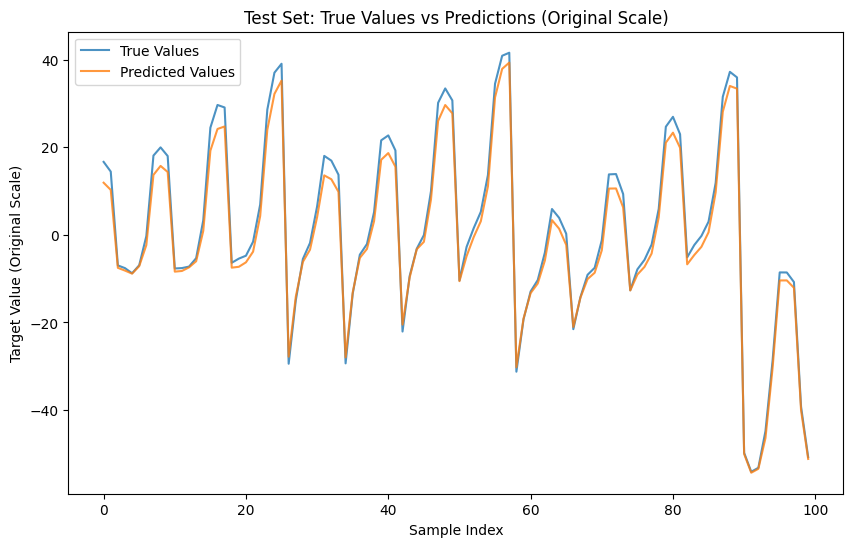

In [ ]:

# Charger les scalers pour normalisation et re-inverse
target_scaler = joblib.load('target_scaler.pkl')  # Scaler utilisé pour la cible

# Configuration de TimeSeriesSplit
n_splits = 5  # Nombre de divisions pour la validation croisée
tscv = TimeSeriesSplit(n_splits=n_splits)

# Liste pour stocker les scores des métriques
mse_scores = []
mae_scores = []
r2_scores = []
rmse_scores = []

# Liste pour les temps d'exécution
validation_times = []

# Parcours des splits de la validation croisée
split_num = 1
for train_idx, val_idx in tscv.split(X_train):
    print(f"\nProcessing Split {split_num}/{n_splits}")
    split_start = time()  # Démarrer le chronomètre pour ce split

    # Division des données en train et validation pour ce split
    X_train_split, X_val_split = X_train[train_idx], X_train[val_idx]
    y_train_split, y_val_split = y_train[train_idx], y_train[val_idx]

    # Définition du modèle Bidirectional LSTM
    model = Sequential()
    model.add(Bidirectional(LSTM(100, activation='relu', return_sequences=True), input_shape=(X_train_split.shape[1], X_train_split.shape[2])))
    model.add(Dropout(0.2))  # Régularisation
    model.add(Bidirectional(LSTM(100, activation='relu')))
    model.add(Dropout(0.2))  # Régularisation
    model.add(Dense(1))  # Couche de sortie pour la régression

    # Compilation du modèle
    model.compile(optimizer='adam', loss='mse')

    # Entraînement du modèle
    history = model.fit(X_train_split, y_train_split,
                        epochs=20,
                        batch_size=64,
                        validation_data=(X_val_split, y_val_split),
                        verbose=0)

    # Prédictions sur le jeu de validation
    y_val_pred = model.predict(X_val_split)

    # Re-inverse pour ramener les prédictions et les valeurs réelles à l'échelle d'origine
    y_val_pred_original = target_scaler.inverse_transform(y_val_pred)
    y_val_original = target_scaler.inverse_transform(y_val_split)

    # Calcul des métriques sur l'échelle originale
    mse = mean_squared_error(y_val_original, y_val_pred_original)
    mae = mean_absolute_error(y_val_original, y_val_pred_original)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val_original, y_val_pred_original)

    # Stockage des scores
    mse_scores.append(mse)
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    r2_scores.append(r2)

    # Calcul du temps d'exécution pour ce split
    split_time = time() - split_start
    validation_times.append(split_time)
    print(f"Split {split_num - 1} Time: {int(split_time // 60)} min {int(split_time % 60)} sec")
    print(f"Split Metrics - MSE: {mse}, MAE: {mae}, RMSE: {rmse}, R²: {r2}")

# Moyennes des métriques sur tous les splits
print("\nCross-Validation Metrics (Original Scale):")
print(f"Average MSE: {np.mean(mse_scores)}")
print(f"Average MAE: {np.mean(mae_scores)}")
print(f"Average RMSE: {np.mean(rmse_scores)}")
print(f"Average R²: {np.mean(r2_scores)}")

# Temps total pour la validation croisée
total_validation_time = sum(validation_times)
print(f"\nTotal Validation Time: {int(total_validation_time // 60)} min {int(total_validation_time % 60)} sec")

model.save('bi-lstm5-1.keras')


# Évaluation finale sur le jeu de test
print("\nTesting on the Test Set...")
test_start = time()  # Démarrer le chronomètre pour le test


# Prédictions sur le jeu de test
y_test_pred = model.predict(X_test)

# Re-inverse pour ramener les prédictions et les valeurs réelles à l'échelle d'origine
y_test_pred_original = target_scaler.inverse_transform(y_test_pred)
y_test_original = target_scaler.inverse_transform(y_test)

# Calcul des métriques sur l'échelle originale
mse_test = mean_squared_error(y_test_original, y_test_pred_original)
mae_test = mean_absolute_error(y_test_original, y_test_pred_original)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test_original, y_test_pred_original)

# Calcul du temps d'exécution pour le test
test_time = time() - test_start
print(f"\nTest Time: {int(test_time // 60)} min {int(test_time % 60)} sec")

# Affichage des métriques sur le jeu de test
print("\nTest Set Metrics (Original Scale):")
print(f"MSE: {mse_test}")
print(f"MAE: {mae_test}")
print(f"RMSE: {rmse_test}")
print(f"R²: {r2_test}")

# Visualisation des résultats sur le jeu de test
plt.figure(figsize=(10, 6))
plt.plot(y_test_original[:100], label="True Values", alpha=0.8)  # Afficher les 100 premières valeurs pour la lisibilité
plt.plot(y_test_pred_original[:100], label="Predicted Values", alpha=0.8)
plt.title("Test Set: True Values vs Predictions (Original Scale)")
plt.xlabel("Sample Index")
plt.ylabel("Target Value (Original Scale)")
plt.legend()
plt.show()



Processing Split 1/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Split 0 Time: 0 min 39 sec
Split Metrics - MSE: 307.8137941331211, MAE: 11.974452822214657, RMSE: 17.544622940750852, R²: 0.36721523884444063

Processing Split 1/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
Split 0 Time: 0 min 58 sec
Split Metrics - MSE: 54.33769328766584, MAE: 5.712603841320476, RMSE: 7.371410535824595, R²: 0.2856243636612543

Processing Split 1/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Split 0 Time: 1 min 48 sec
Split Metrics - MSE: 296.38099804976497, MAE: 10.445549777427276, RMSE: 17.215719504271814, R²: 0.7126043235321655

Processing Split 1/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
Split 0 Time: 1 min 42 sec
Split Metrics - MSE: 63.25086773427447, MAE: 6.794730668877681, RMSE: 7.953041414092754, R²: 0.8488187856009763

Processing Split 1/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
Split 0 Time: 1 min 52 sec
Split Metrics - MSE: 12.00843610401629, MAE: 2.4988889626142727, RMSE: 3.4653190479400724, R²: 0.9897901690899523

Processing Split 1/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
Split 0 Time: 2 min 44 sec
Split Metrics - MSE: 28.600501919736264, MAE: 4.4952102513265695, RMSE: 5.347943709477154, R²: 0.9494824179539503

Processing Split 1/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
Split 0 Time: 2 min 56 sec
Split Metrics - MSE: 4.59539571486306, MAE: 1.514093026818943, RMSE: 2.1436874107161845, R²: 0.9944401968338833

Cross-Validation Metrics (Original Scale):
Average MSE: 109.56966956334887
Average MAE: 6.2050756215142675
Average RMSE: 8.720249223296204
Average R²: 0.735425070788089

Total Validation Time: 12 min 41 sec

Testing on the Test Set...
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

Test Time: 0 min 1 sec

Test Set Metrics (Original Scale):
MSE: 69.72344007242094
MAE: 2.4255140833070397
RMSE: 8.350056291571988
R²: 0.9244336686105906


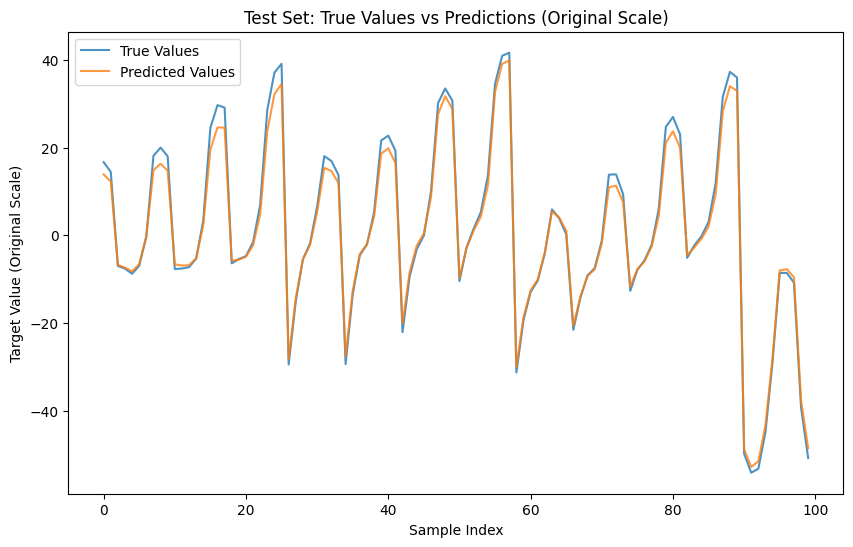

In [ ]:

# Charger les scalers pour normalisation et re-inverse
target_scaler = joblib.load('target_scaler.pkl')  # Scaler utilisé pour la cible

# Configuration de TimeSeriesSplit
n_splits = 7  # Nombre de divisions pour la validation croisée
tscv = TimeSeriesSplit(n_splits=n_splits)

# Liste pour stocker les scores des métriques
mse_scores = []
mae_scores = []
r2_scores = []
rmse_scores = []

# Liste pour les temps d'exécution
validation_times = []

# Parcours des splits de la validation croisée
split_num = 1
for train_idx, val_idx in tscv.split(X_train):
    print(f"\nProcessing Split {split_num}/{n_splits}")
    split_start = time()  # Démarrer le chronomètre pour ce split

    # Division des données en train et validation pour ce split
    X_train_split, X_val_split = X_train[train_idx], X_train[val_idx]
    y_train_split, y_val_split = y_train[train_idx], y_train[val_idx]

    # Définition du modèle Bidirectional LSTM
    model = Sequential()
    model.add(Bidirectional(LSTM(100, activation='relu', return_sequences=True), input_shape=(X_train_split.shape[1], X_train_split.shape[2])))
    model.add(Dropout(0.2))  # Régularisation
    model.add(Bidirectional(LSTM(100, activation='relu')))
    model.add(Dropout(0.2))  # Régularisation
    model.add(Dense(1))  # Couche de sortie pour la régression

    # Compilation du modèle
    model.compile(optimizer='adam', loss='mse')

    # Entraînement du modèle
    history = model.fit(X_train_split, y_train_split,
                        epochs=20,
                        batch_size=64,
                        validation_data=(X_val_split, y_val_split),
                        verbose=0)

    # Prédictions sur le jeu de validation
    y_val_pred = model.predict(X_val_split)

    # Re-inverse pour ramener les prédictions et les valeurs réelles à l'échelle d'origine
    y_val_pred_original = target_scaler.inverse_transform(y_val_pred)
    y_val_original = target_scaler.inverse_transform(y_val_split)

    # Calcul des métriques sur l'échelle originale
    mse = mean_squared_error(y_val_original, y_val_pred_original)
    mae = mean_absolute_error(y_val_original, y_val_pred_original)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val_original, y_val_pred_original)

    # Stockage des scores
    mse_scores.append(mse)
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    r2_scores.append(r2)

    # Calcul du temps d'exécution pour ce split
    split_time = time() - split_start
    validation_times.append(split_time)
    print(f"Split {split_num - 1} Time: {int(split_time // 60)} min {int(split_time % 60)} sec")
    print(f"Split Metrics - MSE: {mse}, MAE: {mae}, RMSE: {rmse}, R²: {r2}")

# Moyennes des métriques sur tous les splits
print("\nCross-Validation Metrics (Original Scale):")
print(f"Average MSE: {np.mean(mse_scores)}")
print(f"Average MAE: {np.mean(mae_scores)}")
print(f"Average RMSE: {np.mean(rmse_scores)}")
print(f"Average R²: {np.mean(r2_scores)}")

# Temps total pour la validation croisée
total_validation_time = sum(validation_times)
print(f"\nTotal Validation Time: {int(total_validation_time // 60)} min {int(total_validation_time % 60)} sec")

model.save('bi-lstm7-1.keras')


# Évaluation finale sur le jeu de test
print("\nTesting on the Test Set...")
test_start = time()  # Démarrer le chronomètre pour le test


# Prédictions sur le jeu de test
y_test_pred = model.predict(X_test)

# Re-inverse pour ramener les prédictions et les valeurs réelles à l'échelle d'origine
y_test_pred_original = target_scaler.inverse_transform(y_test_pred)
y_test_original = target_scaler.inverse_transform(y_test)

# Calcul des métriques sur l'échelle originale
mse_test = mean_squared_error(y_test_original, y_test_pred_original)
mae_test = mean_absolute_error(y_test_original, y_test_pred_original)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test_original, y_test_pred_original)

# Calcul du temps d'exécution pour le test
test_time = time() - test_start
print(f"\nTest Time: {int(test_time // 60)} min {int(test_time % 60)} sec")

# Affichage des métriques sur le jeu de test
print("\nTest Set Metrics (Original Scale):")
print(f"MSE: {mse_test}")
print(f"MAE: {mae_test}")
print(f"RMSE: {rmse_test}")
print(f"R²: {r2_test}")

# Visualisation des résultats sur le jeu de test
plt.figure(figsize=(10, 6))
plt.plot(y_test_original[:100], label="True Values", alpha=0.8)  # Afficher les 100 premières valeurs pour la lisibilité
plt.plot(y_test_pred_original[:100], label="Predicted Values", alpha=0.8)
plt.title("Test Set: True Values vs Predictions (Original Scale)")
plt.xlabel("Sample Index")
plt.ylabel("Target Value (Original Scale)")
plt.legend()
plt.show()



Processing Split 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
Split 0 Time: 0 min 36 sec
Split Metrics - MSE: 1585.9733693252836, MAE: 30.415140367576257, RMSE: 39.82428115264962, R²: -1.0290157776340565

Processing Split 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
Split 0 Time: 0 min 55 sec
Split Metrics - MSE: 245.47749589106243, MAE: 12.93914968129433, RMSE: 15.667721464560902, R²: 0.5829208641979711

Processing Split 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
Split 0 Time: 1 min 0 sec
Split Metrics - MSE: 93.07215565091471, MAE: 7.819477568774764, RMSE: 9.647391131850865, R²: -0.942572271423447

Processing Split 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
Split 0 Time: 1 min 31 sec
Split Metrics - MSE: 404.5254249451538, MAE: 12.32810906683191, RMSE: 20.112817429319886, R²: 0.721228217272853

Processing Split 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
Split 0 Time: 1 min 39 sec
Split Metrics - MSE: 41.985125514953225, MAE: 4.989818183593057, RMSE: 6.479593005347884, R²: 0.8885306662726664

Processing Split 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
Split 0 Time: 1 min 50 sec
Split Metrics - MSE: 57.70673420678535, MAE: 6.729949452455361, RMSE: 7.596494863210621, R²: 0.48525284926912404

Processing Split 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
Split 0 Time: 1 min 46 sec
Split Metrics - MSE: 12.342411544131236, MAE: 2.6122199144899074, RMSE: 3.5131768449839296, R²: 0.9849403344002148

Processing Split 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
Split 0 Time: 2 min 22 sec
Split Metrics - MSE: 9.738843641491128, MAE: 2.0673553844108747, RMSE: 3.1207120407835016, R²: 0.9786859398231728

Processing Split 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
Split 0 Time: 2 min 37 sec
Split Metrics - MSE: 8.967094901525972, MAE: 2.3282688393117676, RMSE: 2.994510795025787, R²: 0.9221656243257329

Processing Split 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
Split 0 Time: 2 min 52 sec
Split Metrics - MSE: 16.01383799332857, MAE: 2.7698518239927936, RMSE: 4.001729375323695, R²: 0.9794337910750041

Cross-Validation Metrics (Original Scale):
Average MSE: 247.58024936146302
Average MAE: 8.499934028273103
Average RMSE: 11.295842810305668
Average R²: 0.45715702375792355

Total Validation Time: 17 min 15 sec

Testing on the Test Set...
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

Test Time: 0 min 2 sec

Test Set Metrics (Original Scale):
MSE: 82.58726759400567
MAE: 3.3849501333390046
RMSE: 9.087753715523197
R²: 0.910491839974158


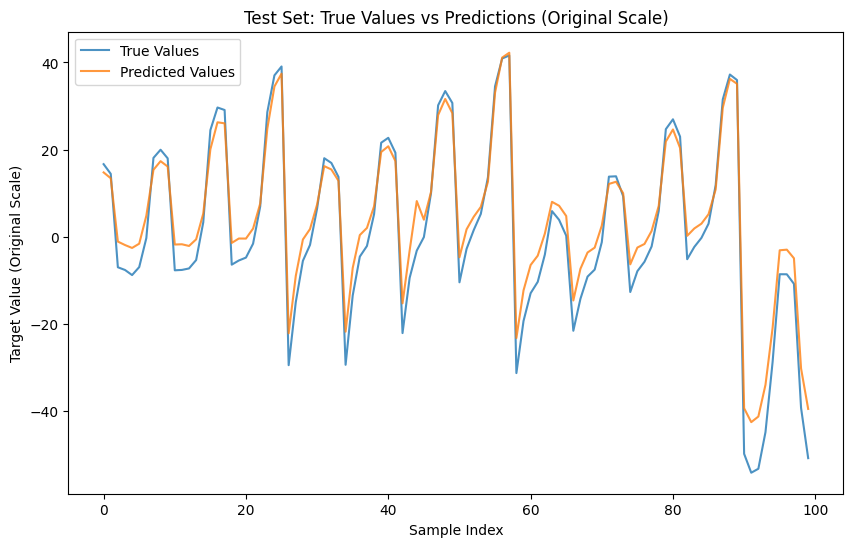

In [ ]:


# Charger les scalers pour normalisation et re-inverse
target_scaler = joblib.load('target_scaler.pkl')  # Scaler utilisé pour la cible

# Configuration de TimeSeriesSplit
n_splits = 10  # Nombre de divisions pour la validation croisée
tscv = TimeSeriesSplit(n_splits=n_splits)

# Liste pour stocker les scores des métriques
mse_scores = []
mae_scores = []
r2_scores = []
rmse_scores = []

# Liste pour les temps d'exécution
validation_times = []

# Parcours des splits de la validation croisée
split_num = 1
for train_idx, val_idx in tscv.split(X_train):
    print(f"\nProcessing Split {split_num}/{n_splits}")
    split_start = time()  # Démarrer le chronomètre pour ce split

    # Division des données en train et validation pour ce split
    X_train_split, X_val_split = X_train[train_idx], X_train[val_idx]
    y_train_split, y_val_split = y_train[train_idx], y_train[val_idx]

    # Définition du modèle Bidirectional LSTM
    model = Sequential()
    model.add(Bidirectional(LSTM(100, activation='relu', return_sequences=True), input_shape=(X_train_split.shape[1], X_train_split.shape[2])))
    model.add(Dropout(0.2))  # Régularisation
    model.add(Bidirectional(LSTM(100, activation='relu')))
    model.add(Dropout(0.2))  # Régularisation
    model.add(Dense(1))  # Couche de sortie pour la régression

    # Compilation du modèle
    model.compile(optimizer='adam', loss='mse')

    # Entraînement du modèle
    history = model.fit(X_train_split, y_train_split,
                        epochs=20,
                        batch_size=64,
                        validation_data=(X_val_split, y_val_split),
                        verbose=0)

    # Prédictions sur le jeu de validation
    y_val_pred = model.predict(X_val_split)

    # Re-inverse pour ramener les prédictions et les valeurs réelles à l'échelle d'origine
    y_val_pred_original = target_scaler.inverse_transform(y_val_pred)
    y_val_original = target_scaler.inverse_transform(y_val_split)

    # Calcul des métriques sur l'échelle originale
    mse = mean_squared_error(y_val_original, y_val_pred_original)
    mae = mean_absolute_error(y_val_original, y_val_pred_original)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val_original, y_val_pred_original)

    # Stockage des scores
    mse_scores.append(mse)
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    r2_scores.append(r2)

    # Calcul du temps d'exécution pour ce split
    split_time = time() - split_start
    validation_times.append(split_time)
    print(f"Split {split_num - 1} Time: {int(split_time // 60)} min {int(split_time % 60)} sec")
    print(f"Split Metrics - MSE: {mse}, MAE: {mae}, RMSE: {rmse}, R²: {r2}")

# Moyennes des métriques sur tous les splits
print("\nCross-Validation Metrics (Original Scale):")
print(f"Average MSE: {np.mean(mse_scores)}")
print(f"Average MAE: {np.mean(mae_scores)}")
print(f"Average RMSE: {np.mean(rmse_scores)}")
print(f"Average R²: {np.mean(r2_scores)}")

# Temps total pour la validation croisée
total_validation_time = sum(validation_times)
print(f"\nTotal Validation Time: {int(total_validation_time // 60)} min {int(total_validation_time % 60)} sec")

model.save('bi-lstm10-1.keras')


# Évaluation finale sur le jeu de test
print("\nTesting on the Test Set...")
test_start = time()  # Démarrer le chronomètre pour le test


# Prédictions sur le jeu de test
y_test_pred = model.predict(X_test)

# Re-inverse pour ramener les prédictions et les valeurs réelles à l'échelle d'origine
y_test_pred_original = target_scaler.inverse_transform(y_test_pred)
y_test_original = target_scaler.inverse_transform(y_test)

# Calcul des métriques sur l'échelle originale
mse_test = mean_squared_error(y_test_original, y_test_pred_original)
mae_test = mean_absolute_error(y_test_original, y_test_pred_original)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test_original, y_test_pred_original)

# Calcul du temps d'exécution pour le test
test_time = time() - test_start
print(f"\nTest Time: {int(test_time // 60)} min {int(test_time % 60)} sec")

# Affichage des métriques sur le jeu de test
print("\nTest Set Metrics (Original Scale):")
print(f"MSE: {mse_test}")
print(f"MAE: {mae_test}")
print(f"RMSE: {rmse_test}")
print(f"R²: {r2_test}")

# Visualisation des résultats sur le jeu de test
plt.figure(figsize=(10, 6))
plt.plot(y_test_original[:100], label="True Values", alpha=0.8)  # Afficher les 100 premières valeurs pour la lisibilité
plt.plot(y_test_pred_original[:100], label="Predicted Values", alpha=0.8)
plt.title("Test Set: True Values vs Predictions (Original Scale)")
plt.xlabel("Sample Index")
plt.ylabel("Target Value (Original Scale)")
plt.legend()
plt.show()


#gru


Processing Split 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Split 0 Time: 0 min 36 sec
Split Metrics - MSE: 1251.2808571286682, MAE: 33.223063570219026, RMSE: 35.37344847662818, R²: -0.5406033772946708

Processing Split 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Split 0 Time: 0 min 53 sec
Split Metrics - MSE: 285.07130034980185, MAE: 13.810936661351308, RMSE: 16.88405461818345, R²: 0.796104208898516

Processing Split 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Split 0 Time: 1 min 7 sec
Split Metrics - MSE: 34.45498331651059, MAE: 4.306406387822904, RMSE: 5.869836736784984, R²: 0.9176970768861916

Processing Split 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Split 0 Time: 1 min 29 sec
Split Metrics - MSE: 25.319301714061467, MAE: 4.270835243984088, RMSE: 5.031828863749389, R²: 0.9636067867845064

Processing Split 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Split 0 Time: 1 min 36 sec
Split Metrics - MSE: 33.29192071411734, MAE: 4.947761368441818, RMSE: 5.769915139247487, R²: 0.9519014234549679

Cross-Validation Metrics (Original Scale):
Average MSE: 325.88367264463193
Average MAE: 12.111800646363829
Average RMSE: 13.785816766918696
Average R²: 0.6177412237459022

Total Validation Time: 5 min 43 sec

Testing on the Test Set...
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Test Time: 0 min 2 sec

Test Set Metrics (Original Scale):
MSE: 96.55544017702738
MAE: 5.2738722571971195
RMSE: 9.826262777731287
R²: 0.8953531210983148


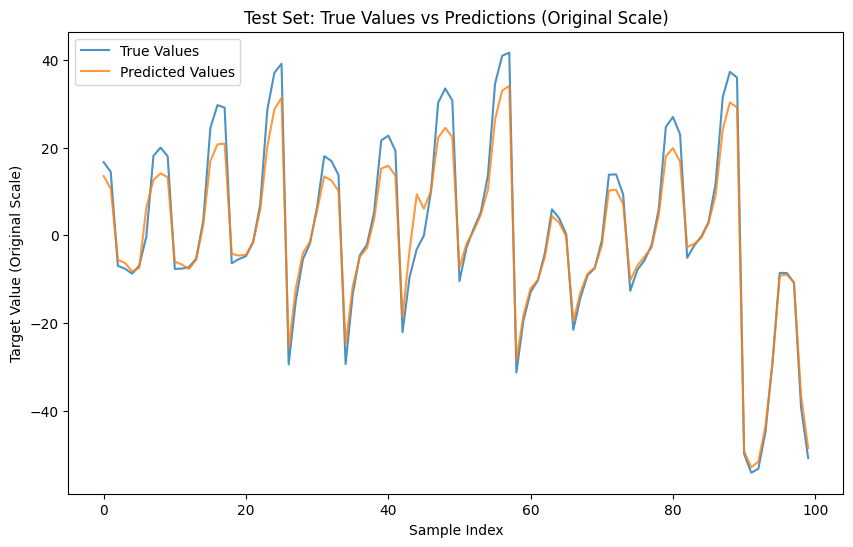

In [ ]:


# Charger les scalers pour normalisation et re-inverse
target_scaler = joblib.load('target_scaler.pkl')  # Scaler utilisé pour la cible

# Configuration de TimeSeriesSplit
n_splits = 5  # Nombre de divisions pour la validation croisée
tscv = TimeSeriesSplit(n_splits=n_splits)

# Liste pour stocker les scores des métriques
mse_scores = []
mae_scores = []
r2_scores = []
rmse_scores = []

# Liste pour les temps d'exécution
validation_times = []

# Parcours des splits de la validation croisée
split_num = 1
for train_idx, val_idx in tscv.split(X_train):
    print(f"\nProcessing Split {split_num}/{n_splits}")
    split_start = time()  # Démarrer le chronomètre pour ce split

    # Division des données en train et validation pour ce split
    X_train_split, X_val_split = X_train[train_idx], X_train[val_idx]
    y_train_split, y_val_split = y_train[train_idx], y_train[val_idx]

    # Définition du modèle  gru
    # Modèle GRU
    model = Sequential()
    model.add(GRU(100, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))  # Régularisation
    model.add(GRU(100, activation='relu'))
    model.add(Dropout(0.2))  # Régularisation
    model.add(Dense(1))  # Couche de sortie pour la régression

    # Compilation du modèle
    model.compile(optimizer='adam', loss='mse')

    # Entraînement du modèle
    history = model.fit(X_train_split, y_train_split,
                        epochs=20,
                        batch_size=64,
                        validation_data=(X_val_split, y_val_split),
                        verbose=0)

    # Prédictions sur le jeu de validation
    y_val_pred = model.predict(X_val_split)

    # Re-inverse pour ramener les prédictions et les valeurs réelles à l'échelle d'origine
    y_val_pred_original = target_scaler.inverse_transform(y_val_pred)
    y_val_original = target_scaler.inverse_transform(y_val_split)

    # Calcul des métriques sur l'échelle originale
    mse = mean_squared_error(y_val_original, y_val_pred_original)
    mae = mean_absolute_error(y_val_original, y_val_pred_original)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val_original, y_val_pred_original)

    # Stockage des scores
    mse_scores.append(mse)
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    r2_scores.append(r2)

    # Calcul du temps d'exécution pour ce split
    split_time = time() - split_start
    validation_times.append(split_time)
    print(f"Split {split_num - 1} Time: {int(split_time // 60)} min {int(split_time % 60)} sec")
    print(f"Split Metrics - MSE: {mse}, MAE: {mae}, RMSE: {rmse}, R²: {r2}")

# Moyennes des métriques sur tous les splits
print("\nCross-Validation Metrics (Original Scale):")
print(f"Average MSE: {np.mean(mse_scores)}")
print(f"Average MAE: {np.mean(mae_scores)}")
print(f"Average RMSE: {np.mean(rmse_scores)}")
print(f"Average R²: {np.mean(r2_scores)}")

# Temps total pour la validation croisée
total_validation_time = sum(validation_times)
print(f"\nTotal Validation Time: {int(total_validation_time // 60)} min {int(total_validation_time % 60)} sec")

model.save('gru5-1.keras')


# Évaluation finale sur le jeu de test
print("\nTesting on the Test Set...")
test_start = time()  # Démarrer le chronomètre pour le test


# Prédictions sur le jeu de test
y_test_pred = model.predict(X_test)

# Re-inverse pour ramener les prédictions et les valeurs réelles à l'échelle d'origine
y_test_pred_original = target_scaler.inverse_transform(y_test_pred)
y_test_original = target_scaler.inverse_transform(y_test)

# Calcul des métriques sur l'échelle originale
mse_test = mean_squared_error(y_test_original, y_test_pred_original)
mae_test = mean_absolute_error(y_test_original, y_test_pred_original)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test_original, y_test_pred_original)

# Calcul du temps d'exécution pour le test
test_time = time() - test_start
print(f"\nTest Time: {int(test_time // 60)} min {int(test_time % 60)} sec")

# Affichage des métriques sur le jeu de test
print("\nTest Set Metrics (Original Scale):")
print(f"MSE: {mse_test}")
print(f"MAE: {mae_test}")
print(f"RMSE: {rmse_test}")
print(f"R²: {r2_test}")

# Visualisation des résultats sur le jeu de test
plt.figure(figsize=(10, 6))
plt.plot(y_test_original[:100], label="True Values", alpha=0.8)  # Afficher les 100 premières valeurs pour la lisibilité
plt.plot(y_test_pred_original[:100], label="Predicted Values", alpha=0.8)
plt.title("Test Set: True Values vs Predictions (Original Scale)")
plt.xlabel("Sample Index")
plt.ylabel("Target Value (Original Scale)")
plt.legend()
plt.show()



Processing Split 1/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Split 0 Time: 0 min 30 sec
Split Metrics - MSE: 759.4069086046053, MAE: 20.86001404467701, RMSE: 27.557338561708118, R²: -0.5611422504133323

Processing Split 1/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Split 0 Time: 0 min 37 sec
Split Metrics - MSE: 62.26987365807018, MAE: 6.674948113411731, RMSE: 7.891126260431408, R²: 0.18134028281773495

Processing Split 1/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Split 0 Time: 0 min 56 sec
Split Metrics - MSE: 289.06291316583525, MAE: 10.67112154570345, RMSE: 17.0018502865375, R²: 0.7197005475462059

Processing Split 1/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Split 0 Time: 1 min 1 sec
Split Metrics - MSE: 58.42054500358263, MAE: 6.4176047292478895, RMSE: 7.643333369910188, R²: 0.8603641458865158

Processing Split 1/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Split 0 Time: 1 min 21 sec
Split Metrics - MSE: 226.6147725472211, MAE: 12.347148507761384, RMSE: 15.05372952285317, R²: 0.8073272415004809

Processing Split 1/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Split 0 Time: 1 min 33 sec
Split Metrics - MSE: 37.931903858019005, MAE: 4.79422903902199, RMSE: 6.158888199831119, R²: 0.9330001945179843

Processing Split 1/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


165/165 ━━━━━━━━━━━━━━━━━━━━ 36s 24ms/step
Split 0 Time: 2 min 18 sec
Split Metrics - MSE: 8.29609177818859, MAE: 2.2005713589457474, RMSE: 2.8802936965157895, R²: 0.9899628584355455

Cross-Validation Metrics (Original Scale):
Average MSE: 206.00042980221744
Average MAE: 9.137948191252743
Average RMSE: 12.026651413969615
Average R²: 0.5615075743273049

Total Validation Time: 8 min 19 sec

Testing on the Test Set...
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step

Test Time: 0 min 6 sec

Test Set Metrics (Original Scale):
MSE: 69.92754399707411
MAE: 3.0412820352294694
RMSE: 8.362269069880142
R²: 0.9242124605808061


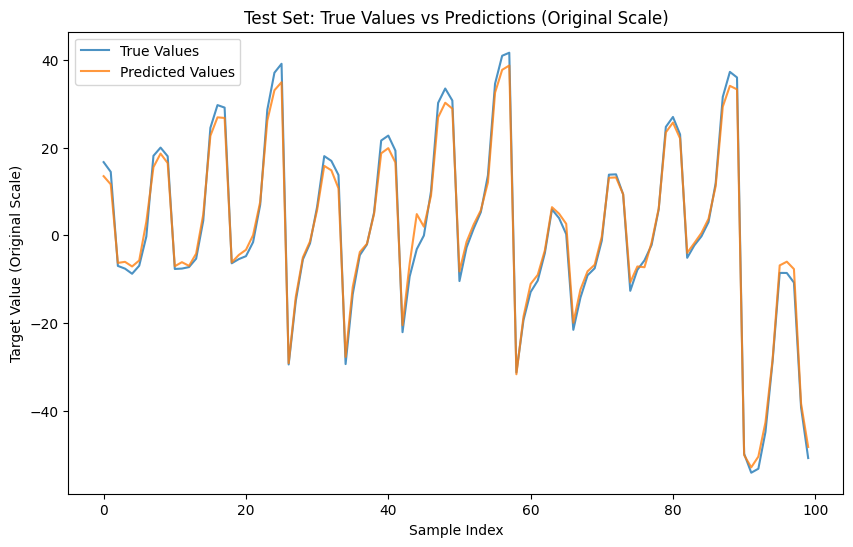

In [ ]:


# Charger les scalers pour normalisation et re-inverse
target_scaler = joblib.load('target_scaler.pkl')  # Scaler utilisé pour la cible

# Configuration de TimeSeriesSplit
n_splits = 7  # Nombre de divisions pour la validation croisée
tscv = TimeSeriesSplit(n_splits=n_splits)

# Liste pour stocker les scores des métriques
mse_scores = []
mae_scores = []
r2_scores = []
rmse_scores = []

# Liste pour les temps d'exécution
validation_times = []

# Parcours des splits de la validation croisée
split_num = 1
for train_idx, val_idx in tscv.split(X_train):
    print(f"\nProcessing Split {split_num}/{n_splits}")
    split_start = time()  # Démarrer le chronomètre pour ce split

    # Division des données en train et validation pour ce split
    X_train_split, X_val_split = X_train[train_idx], X_train[val_idx]
    y_train_split, y_val_split = y_train[train_idx], y_train[val_idx]

    # Définition du modèle  gru
    # Modèle GRU
    model = Sequential()
    model.add(GRU(100, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))  # Régularisation
    model.add(GRU(100, activation='relu'))
    model.add(Dropout(0.2))  # Régularisation
    model.add(Dense(1))  # Couche de sortie pour la régression

    # Compilation du modèle
    model.compile(optimizer='adam', loss='mse')

    # Entraînement du modèle
    history = model.fit(X_train_split, y_train_split,
                        epochs=20,
                        batch_size=64,
                        validation_data=(X_val_split, y_val_split),
                        verbose=0)

    # Prédictions sur le jeu de validation
    y_val_pred = model.predict(X_val_split)

    # Re-inverse pour ramener les prédictions et les valeurs réelles à l'échelle d'origine
    y_val_pred_original = target_scaler.inverse_transform(y_val_pred)
    y_val_original = target_scaler.inverse_transform(y_val_split)

    # Calcul des métriques sur l'échelle originale
    mse = mean_squared_error(y_val_original, y_val_pred_original)
    mae = mean_absolute_error(y_val_original, y_val_pred_original)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val_original, y_val_pred_original)

    # Stockage des scores
    mse_scores.append(mse)
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    r2_scores.append(r2)

    # Calcul du temps d'exécution pour ce split
    split_time = time() - split_start
    validation_times.append(split_time)
    print(f"Split {split_num - 1} Time: {int(split_time // 60)} min {int(split_time % 60)} sec")
    print(f"Split Metrics - MSE: {mse}, MAE: {mae}, RMSE: {rmse}, R²: {r2}")

# Moyennes des métriques sur tous les splits
print("\nCross-Validation Metrics (Original Scale):")
print(f"Average MSE: {np.mean(mse_scores)}")
print(f"Average MAE: {np.mean(mae_scores)}")
print(f"Average RMSE: {np.mean(rmse_scores)}")
print(f"Average R²: {np.mean(r2_scores)}")

# Temps total pour la validation croisée
total_validation_time = sum(validation_times)
print(f"\nTotal Validation Time: {int(total_validation_time // 60)} min {int(total_validation_time % 60)} sec")

model.save('gru7-1.keras')


# Évaluation finale sur le jeu de test
print("\nTesting on the Test Set...")
test_start = time()  # Démarrer le chronomètre pour le test


# Prédictions sur le jeu de test
y_test_pred = model.predict(X_test)

# Re-inverse pour ramener les prédictions et les valeurs réelles à l'échelle d'origine
y_test_pred_original = target_scaler.inverse_transform(y_test_pred)
y_test_original = target_scaler.inverse_transform(y_test)

# Calcul des métriques sur l'échelle originale
mse_test = mean_squared_error(y_test_original, y_test_pred_original)
mae_test = mean_absolute_error(y_test_original, y_test_pred_original)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test_original, y_test_pred_original)

# Calcul du temps d'exécution pour le test
test_time = time() - test_start
print(f"\nTest Time: {int(test_time // 60)} min {int(test_time % 60)} sec")

# Affichage des métriques sur le jeu de test
print("\nTest Set Metrics (Original Scale):")
print(f"MSE: {mse_test}")
print(f"MAE: {mae_test}")
print(f"RMSE: {rmse_test}")
print(f"R²: {r2_test}")

# Visualisation des résultats sur le jeu de test
plt.figure(figsize=(10, 6))
plt.plot(y_test_original[:100], label="True Values", alpha=0.8)  # Afficher les 100 premières valeurs pour la lisibilité
plt.plot(y_test_pred_original[:100], label="Predicted Values", alpha=0.8)
plt.title("Test Set: True Values vs Predictions (Original Scale)")
plt.xlabel("Sample Index")
plt.ylabel("Target Value (Original Scale)")
plt.legend()
plt.show()



Processing Split 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Split 0 Time: 0 min 30 sec
Split Metrics - MSE: 2790.850182861627, MAE: 42.41449358286585, RMSE: 52.82849782893346, R²: -2.57047549698025

Processing Split 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Split 0 Time: 0 min 45 sec
Split Metrics - MSE: 287.50601388971364, MAE: 13.959749190702262, RMSE: 16.956002296818482, R²: 0.5115122085805268

Processing Split 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Split 0 Time: 0 min 40 sec
Split Metrics - MSE: 33.551808612468086, MAE: 4.566316323605992, RMSE: 5.792392304779441, R²: 0.299717379372352

Processing Split 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Split 0 Time: 0 min 53 sec
Split Metrics - MSE: 302.19412367092, MAE: 12.015285622339512, RMSE: 17.383731580731453, R²: 0.7917480845688942

Processing Split 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Split 0 Time: 0 min 55 sec
Split Metrics - MSE: 150.09705213741984, MAE: 9.569901645219758, RMSE: 12.251410210152128, R²: 0.6014965254721909

Processing Split 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Split 0 Time: 1 min 11 sec
Split Metrics - MSE: 16.88230930512807, MAE: 3.1830944903361873, RMSE: 4.108808745260367, R²: 0.8494088994634146

Processing Split 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Split 0 Time: 1 min 23 sec
Split Metrics - MSE: 28.750113984123693, MAE: 4.654759669095124, RMSE: 5.36191327644561, R²: 0.9649203803479974

Processing Split 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Split 0 Time: 1 min 31 sec
Split Metrics - MSE: 28.49052681855074, MAE: 4.016631105929263, RMSE: 5.337651807541472, R²: 0.9376467242483499

Processing Split 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Split 0 Time: 1 min 34 sec
Split Metrics - MSE: 19.042596721819258, MAE: 3.8525608958051056, RMSE: 4.363782387083395, R²: 0.834710277594205

Processing Split 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Split 0 Time: 1 min 37 sec
Split Metrics - MSE: 16.328188807213646, MAE: 3.3306081614745326, RMSE: 4.0408153641577895, R²: 0.9790300774545219

Cross-Validation Metrics (Original Scale):
Average MSE: 367.36929168089847
Average MAE: 10.15634006873736
Average RMSE: 12.842500580190357
Average R²: 0.4199715060122203

Total Validation Time: 11 min 2 sec

Testing on the Test Set...
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Test Time: 0 min 1 sec

Test Set Metrics (Original Scale):
MSE: 86.62081425335978
MAE: 4.7001983712727435
RMSE: 9.307030367059076
R²: 0.9061202782265045


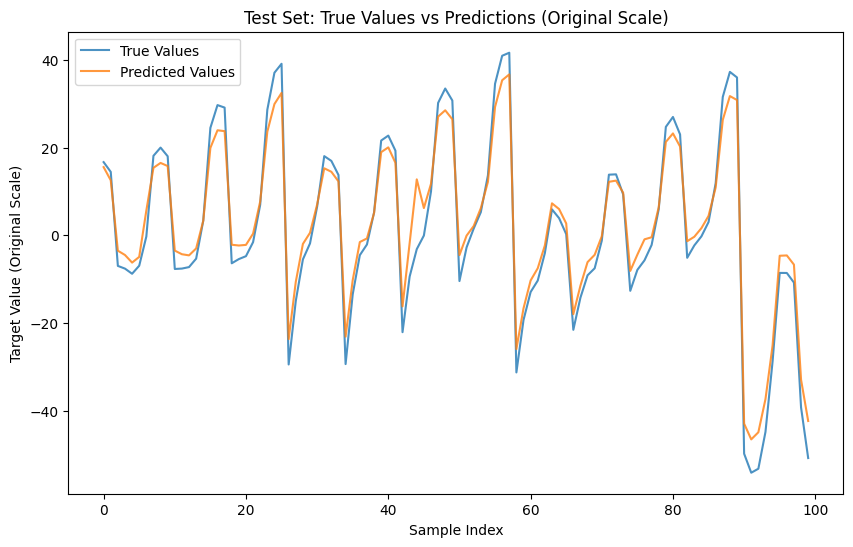

In [ ]:

# Charger les scalers pour normalisation et re-inverse
target_scaler = joblib.load('target_scaler.pkl')  # Scaler utilisé pour la cible

# Configuration de TimeSeriesSplit
n_splits = 10  # Nombre de divisions pour la validation croisée
tscv = TimeSeriesSplit(n_splits=n_splits)

# Liste pour stocker les scores des métriques
mse_scores = []
mae_scores = []
r2_scores = []
rmse_scores = []

# Liste pour les temps d'exécution
validation_times = []

# Parcours des splits de la validation croisée
split_num = 1
for train_idx, val_idx in tscv.split(X_train):
    print(f"\nProcessing Split {split_num}/{n_splits}")
    split_start = time()  # Démarrer le chronomètre pour ce split

    # Division des données en train et validation pour ce split
    X_train_split, X_val_split = X_train[train_idx], X_train[val_idx]
    y_train_split, y_val_split = y_train[train_idx], y_train[val_idx]

    # Définition du modèle  gru
    # Modèle GRU
    model = Sequential()
    model.add(GRU(100, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))  # Régularisation
    model.add(GRU(100, activation='relu'))
    model.add(Dropout(0.2))  # Régularisation
    model.add(Dense(1))  # Couche de sortie pour la régression

    # Compilation du modèle
    model.compile(optimizer='adam', loss='mse')

    # Entraînement du modèle
    history = model.fit(X_train_split, y_train_split,
                        epochs=20,
                        batch_size=64,
                        validation_data=(X_val_split, y_val_split),
                        verbose=0)

    # Prédictions sur le jeu de validation
    y_val_pred = model.predict(X_val_split)

    # Re-inverse pour ramener les prédictions et les valeurs réelles à l'échelle d'origine
    y_val_pred_original = target_scaler.inverse_transform(y_val_pred)
    y_val_original = target_scaler.inverse_transform(y_val_split)

    # Calcul des métriques sur l'échelle originale
    mse = mean_squared_error(y_val_original, y_val_pred_original)
    mae = mean_absolute_error(y_val_original, y_val_pred_original)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val_original, y_val_pred_original)

    # Stockage des scores
    mse_scores.append(mse)
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    r2_scores.append(r2)

    # Calcul du temps d'exécution pour ce split
    split_time = time() - split_start
    validation_times.append(split_time)
    print(f"Split {split_num - 1} Time: {int(split_time // 60)} min {int(split_time % 60)} sec")
    print(f"Split Metrics - MSE: {mse}, MAE: {mae}, RMSE: {rmse}, R²: {r2}")

# Moyennes des métriques sur tous les splits
print("\nCross-Validation Metrics (Original Scale):")
print(f"Average MSE: {np.mean(mse_scores)}")
print(f"Average MAE: {np.mean(mae_scores)}")
print(f"Average RMSE: {np.mean(rmse_scores)}")
print(f"Average R²: {np.mean(r2_scores)}")

# Temps total pour la validation croisée
total_validation_time = sum(validation_times)
print(f"\nTotal Validation Time: {int(total_validation_time // 60)} min {int(total_validation_time % 60)} sec")

model.save('gru10-1.keras')


# Évaluation finale sur le jeu de test
print("\nTesting on the Test Set...")
test_start = time()  # Démarrer le chronomètre pour le test


# Prédictions sur le jeu de test
y_test_pred = model.predict(X_test)

# Re-inverse pour ramener les prédictions et les valeurs réelles à l'échelle d'origine
y_test_pred_original = target_scaler.inverse_transform(y_test_pred)
y_test_original = target_scaler.inverse_transform(y_test)

# Calcul des métriques sur l'échelle originale
mse_test = mean_squared_error(y_test_original, y_test_pred_original)
mae_test = mean_absolute_error(y_test_original, y_test_pred_original)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test_original, y_test_pred_original)

# Calcul du temps d'exécution pour le test
test_time = time() - test_start
print(f"\nTest Time: {int(test_time // 60)} min {int(test_time % 60)} sec")

# Affichage des métriques sur le jeu de test
print("\nTest Set Metrics (Original Scale):")
print(f"MSE: {mse_test}")
print(f"MAE: {mae_test}")
print(f"RMSE: {rmse_test}")
print(f"R²: {r2_test}")

# Visualisation des résultats sur le jeu de test
plt.figure(figsize=(10, 6))
plt.plot(y_test_original[:100], label="True Values", alpha=0.8)  # Afficher les 100 premières valeurs pour la lisibilité
plt.plot(y_test_pred_original[:100], label="Predicted Values", alpha=0.8)
plt.title("Test Set: True Values vs Predictions (Original Scale)")
plt.xlabel("Sample Index")
plt.ylabel("Target Value (Original Scale)")
plt.legend()
plt.show()


#RNN


Processing Split 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Split 0 Time: 0 min 35 sec
Split Metrics - MSE: 718.7637505044212, MAE: 26.029748435150182, RMSE: 26.809769683912265, R²: 0.11504291367079578

Processing Split 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Split 0 Time: 0 min 39 sec
Split Metrics - MSE: 9.133866303562739, MAE: 2.2657201729131167, RMSE: 3.0222286980906556, R²: 0.9934670487927235

Processing Split 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Split 0 Time: 0 min 50 sec
Split Metrics - MSE: 8.019323981359818, MAE: 2.169455042270574, RMSE: 2.831841093945742, R²: 0.9808441699419921

Processing Split 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Split 0 Time: 1 min 0 sec
Split Metrics - MSE: 5.629240890597634, MAE: 1.890276330909788, RMSE: 2.3726021349138238, R²: 0.9919086961288858

Processing Split 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


220/220 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Split 0 Time: 1 min 27 sec
Split Metrics - MSE: 2.4549771832157297, MAE: 1.1552954324898206, RMSE: 1.5668366804538787, R²: 0.9964531662508395

Cross-Validation Metrics (Original Scale):
Average MSE: 148.80023177263143
Average MAE: 6.702099082746696
Average RMSE: 7.3206556582632745
Average R²: 0.8155431989570474

Total Validation Time: 4 min 34 sec

Testing on the Test Set...
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Test Time: 0 min 1 sec

Test Set Metrics (Original Scale):
MSE: 65.1121967657183
MAE: 1.3932599124112812
RMSE: 8.069212896294054
R²: 0.9294313385400943


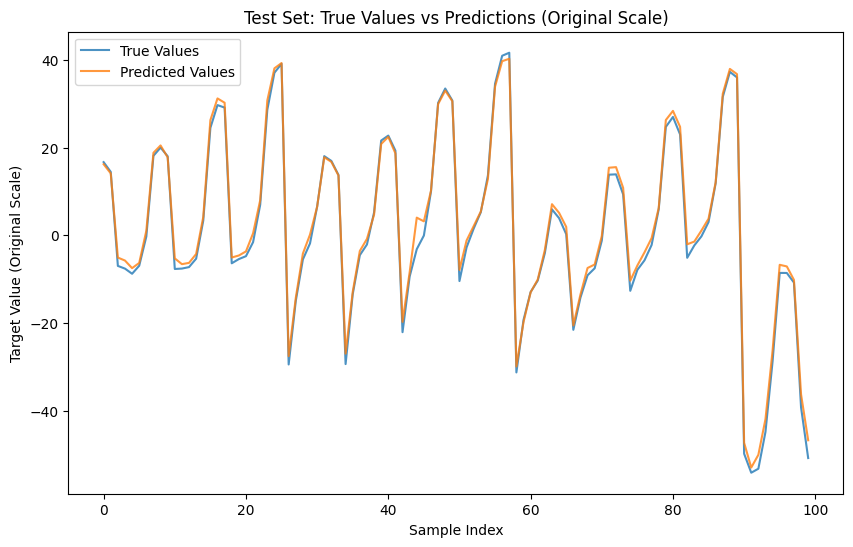

In [ ]:


# Charger les scalers pour normalisation et re-inverse
target_scaler = joblib.load('target_scaler.pkl')  # Scaler utilisé pour la cible

# Configuration de TimeSeriesSplit
n_splits = 5  # Nombre de divisions pour la validation croisée
tscv = TimeSeriesSplit(n_splits=n_splits)

# Liste pour stocker les scores des métriques
mse_scores = []
mae_scores = []
r2_scores = []
rmse_scores = []

# Liste pour les temps d'exécution
validation_times = []

# Parcours des splits de la validation croisée
split_num = 1
for train_idx, val_idx in tscv.split(X_train):
    print(f"\nProcessing Split {split_num}/{n_splits}")
    split_start = time()  # Démarrer le chronomètre pour ce split

    # Division des données en train et validation pour ce split
    X_train_split, X_val_split = X_train[train_idx], X_train[val_idx]
    y_train_split, y_val_split = y_train[train_idx], y_train[val_idx]

    # Définition du modèle  rnn
    model = Sequential()
    model.add(SimpleRNN(100, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(SimpleRNN(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))  # Couche de sortie

    # Compilation du modèle
    model.compile(optimizer='adam', loss='mse')

    # Entraînement du modèle
    history = model.fit(X_train_split, y_train_split,
                        epochs=20,
                        batch_size=64,
                        validation_data=(X_val_split, y_val_split),
                        verbose=0)

    # Prédictions sur le jeu de validation
    y_val_pred = model.predict(X_val_split)

    # Re-inverse pour ramener les prédictions et les valeurs réelles à l'échelle d'origine
    y_val_pred_original = target_scaler.inverse_transform(y_val_pred)
    y_val_original = target_scaler.inverse_transform(y_val_split)

    # Calcul des métriques sur l'échelle originale
    mse = mean_squared_error(y_val_original, y_val_pred_original)
    mae = mean_absolute_error(y_val_original, y_val_pred_original)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val_original, y_val_pred_original)

    # Stockage des scores
    mse_scores.append(mse)
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    r2_scores.append(r2)

    # Calcul du temps d'exécution pour ce split
    split_time = time() - split_start
    validation_times.append(split_time)
    print(f"Split {split_num - 1} Time: {int(split_time // 60)} min {int(split_time % 60)} sec")
    print(f"Split Metrics - MSE: {mse}, MAE: {mae}, RMSE: {rmse}, R²: {r2}")

# Moyennes des métriques sur tous les splits
print("\nCross-Validation Metrics (Original Scale):")
print(f"Average MSE: {np.mean(mse_scores)}")
print(f"Average MAE: {np.mean(mae_scores)}")
print(f"Average RMSE: {np.mean(rmse_scores)}")
print(f"Average R²: {np.mean(r2_scores)}")

# Temps total pour la validation croisée
total_validation_time = sum(validation_times)
print(f"\nTotal Validation Time: {int(total_validation_time // 60)} min {int(total_validation_time % 60)} sec")

model.save('rnn5-1.keras')


# Évaluation finale sur le jeu de test
print("\nTesting on the Test Set...")
test_start = time()  # Démarrer le chronomètre pour le test


# Prédictions sur le jeu de test
y_test_pred = model.predict(X_test)

# Re-inverse pour ramener les prédictions et les valeurs réelles à l'échelle d'origine
y_test_pred_original = target_scaler.inverse_transform(y_test_pred)
y_test_original = target_scaler.inverse_transform(y_test)

# Calcul des métriques sur l'échelle originale
mse_test = mean_squared_error(y_test_original, y_test_pred_original)
mae_test = mean_absolute_error(y_test_original, y_test_pred_original)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test_original, y_test_pred_original)

# Calcul du temps d'exécution pour le test
test_time = time() - test_start
print(f"\nTest Time: {int(test_time // 60)} min {int(test_time % 60)} sec")

# Affichage des métriques sur le jeu de test
print("\nTest Set Metrics (Original Scale):")
print(f"MSE: {mse_test}")
print(f"MAE: {mae_test}")
print(f"RMSE: {rmse_test}")
print(f"R²: {r2_test}")

# Visualisation des résultats sur le jeu de test
plt.figure(figsize=(10, 6))
plt.plot(y_test_original[:100], label="True Values", alpha=0.8)  # Afficher les 100 premières valeurs pour la lisibilité
plt.plot(y_test_pred_original[:100], label="Predicted Values", alpha=0.8)
plt.title("Test Set: True Values vs Predictions (Original Scale)")
plt.xlabel("Sample Index")
plt.ylabel("Target Value (Original Scale)")
plt.legend()
plt.show()



Processing Split 1/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Split 0 Time: 0 min 19 sec
Split Metrics - MSE: 407.01256746683686, MAE: 18.802229789709294, RMSE: 20.17455247252927, R²: 0.1632884711448982

Processing Split 1/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Split 0 Time: 0 min 37 sec
Split Metrics - MSE: 24.518020665739705, MAE: 3.469183785978837, RMSE: 4.951567495827933, R²: 0.6776624925513708

Processing Split 1/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Split 0 Time: 0 min 39 sec
Split Metrics - MSE: 47.408970068598336, MAE: 5.273450331655517, RMSE: 6.885417203670257, R²: 0.9540283178976934

Processing Split 1/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Split 0 Time: 0 min 48 sec
Split Metrics - MSE: 7.283004614537926, MAE: 2.191520333164329, RMSE: 2.6987042473264693, R²: 0.9825922786273034

Processing Split 1/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Split 0 Time: 0 min 54 sec
Split Metrics - MSE: 5.693760091797029, MAE: 1.6124186800065563, RMSE: 2.386160114451046, R²: 0.9951590425867209

Processing Split 1/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Split 0 Time: 1 min 1 sec
Split Metrics - MSE: 4.405149574461157, MAE: 1.6476889644106165, RMSE: 2.0988448190519366, R²: 0.9922191049067081

Processing Split 1/7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Split 0 Time: 1 min 23 sec
Split Metrics - MSE: 11.173230743097685, MAE: 2.7035687253826075, RMSE: 3.342638290796311, R²: 0.9864819120015481

Cross-Validation Metrics (Original Scale):
Average MSE: 72.49924331786696
Average MAE: 5.100008658615394
Average RMSE: 6.076840663379031
Average R²: 0.8216330885308919

Total Validation Time: 5 min 44 sec

Testing on the Test Set...
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Test Time: 0 min 1 sec

Test Set Metrics (Original Scale):
MSE: 82.21560341431804
MAE: 3.4245529393822864
RMSE: 9.067282030152036
R²: 0.9108946499694577


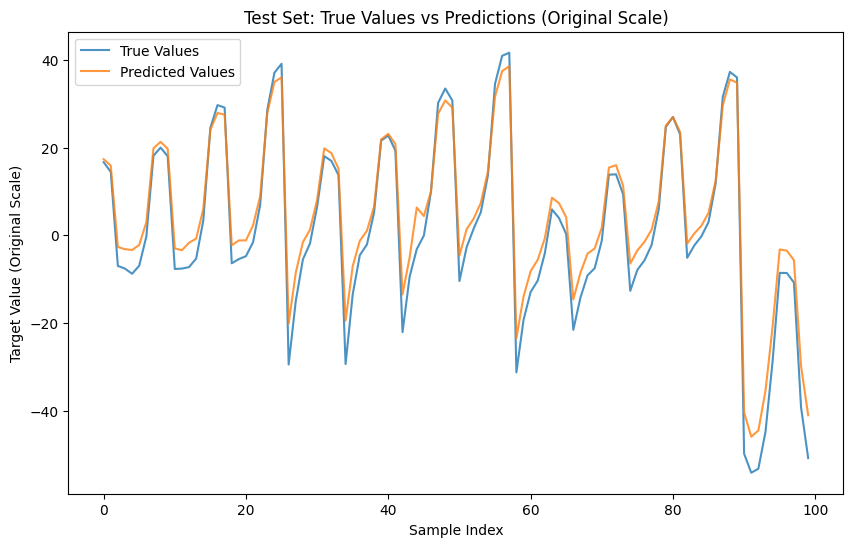

In [ ]:

# Charger les scalers pour normalisation et re-inverse
target_scaler = joblib.load('target_scaler.pkl')  # Scaler utilisé pour la cible

# Configuration de TimeSeriesSplit
n_splits = 7  # Nombre de divisions pour la validation croisée
tscv = TimeSeriesSplit(n_splits=n_splits)

# Liste pour stocker les scores des métriques
mse_scores = []
mae_scores = []
r2_scores = []
rmse_scores = []

# Liste pour les temps d'exécution
validation_times = []

# Parcours des splits de la validation croisée
split_num = 1
for train_idx, val_idx in tscv.split(X_train):
    print(f"\nProcessing Split {split_num}/{n_splits}")
    split_start = time()  # Démarrer le chronomètre pour ce split

    # Division des données en train et validation pour ce split
    X_train_split, X_val_split = X_train[train_idx], X_train[val_idx]
    y_train_split, y_val_split = y_train[train_idx], y_train[val_idx]

    # Définition du modèle  rnn
    model = Sequential()
    model.add(SimpleRNN(100, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(SimpleRNN(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))  # Couche de sortie

    # Compilation du modèle
    model.compile(optimizer='adam', loss='mse')

    # Entraînement du modèle
    history = model.fit(X_train_split, y_train_split,
                        epochs=20,
                        batch_size=64,
                        validation_data=(X_val_split, y_val_split),
                        verbose=0)

    # Prédictions sur le jeu de validation
    y_val_pred = model.predict(X_val_split)

    # Re-inverse pour ramener les prédictions et les valeurs réelles à l'échelle d'origine
    y_val_pred_original = target_scaler.inverse_transform(y_val_pred)
    y_val_original = target_scaler.inverse_transform(y_val_split)

    # Calcul des métriques sur l'échelle originale
    mse = mean_squared_error(y_val_original, y_val_pred_original)
    mae = mean_absolute_error(y_val_original, y_val_pred_original)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val_original, y_val_pred_original)

    # Stockage des scores
    mse_scores.append(mse)
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    r2_scores.append(r2)

    # Calcul du temps d'exécution pour ce split
    split_time = time() - split_start
    validation_times.append(split_time)
    print(f"Split {split_num - 1} Time: {int(split_time // 60)} min {int(split_time % 60)} sec")
    print(f"Split Metrics - MSE: {mse}, MAE: {mae}, RMSE: {rmse}, R²: {r2}")

# Moyennes des métriques sur tous les splits
print("\nCross-Validation Metrics (Original Scale):")
print(f"Average MSE: {np.mean(mse_scores)}")
print(f"Average MAE: {np.mean(mae_scores)}")
print(f"Average RMSE: {np.mean(rmse_scores)}")
print(f"Average R²: {np.mean(r2_scores)}")

# Temps total pour la validation croisée
total_validation_time = sum(validation_times)
print(f"\nTotal Validation Time: {int(total_validation_time // 60)} min {int(total_validation_time % 60)} sec")

model.save('rnn7-1.keras')


# Évaluation finale sur le jeu de test
print("\nTesting on the Test Set...")
test_start = time()  # Démarrer le chronomètre pour le test


# Prédictions sur le jeu de test
y_test_pred = model.predict(X_test)

# Re-inverse pour ramener les prédictions et les valeurs réelles à l'échelle d'origine
y_test_pred_original = target_scaler.inverse_transform(y_test_pred)
y_test_original = target_scaler.inverse_transform(y_test)

# Calcul des métriques sur l'échelle originale
mse_test = mean_squared_error(y_test_original, y_test_pred_original)
mae_test = mean_absolute_error(y_test_original, y_test_pred_original)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test_original, y_test_pred_original)

# Calcul du temps d'exécution pour le test
test_time = time() - test_start
print(f"\nTest Time: {int(test_time // 60)} min {int(test_time % 60)} sec")

# Affichage des métriques sur le jeu de test
print("\nTest Set Metrics (Original Scale):")
print(f"MSE: {mse_test}")
print(f"MAE: {mae_test}")
print(f"RMSE: {rmse_test}")
print(f"R²: {r2_test}")

# Visualisation des résultats sur le jeu de test
plt.figure(figsize=(10, 6))
plt.plot(y_test_original[:100], label="True Values", alpha=0.8)  # Afficher les 100 premières valeurs pour la lisibilité
plt.plot(y_test_pred_original[:100], label="Predicted Values", alpha=0.8)
plt.title("Test Set: True Values vs Predictions (Original Scale)")
plt.xlabel("Sample Index")
plt.ylabel("Target Value (Original Scale)")
plt.legend()
plt.show()



Processing Split 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Split 0 Time: 0 min 18 sec
Split Metrics - MSE: 20442.20325725001, MAE: 141.57458854554216, RMSE: 142.9762331901705, R²: -25.152742373100665

Processing Split 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Split 0 Time: 0 min 29 sec
Split Metrics - MSE: 292.88839744568025, MAE: 14.263156044699977, RMSE: 17.113982512719833, R²: 0.5023672567228061

Processing Split 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Split 0 Time: 0 min 36 sec
Split Metrics - MSE: 85.084080179535, MAE: 8.943047264814508, RMSE: 9.224103218174383, R²: -0.7758477145007396

Processing Split 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Split 0 Time: 0 min 41 sec
Split Metrics - MSE: 53.87055334772839, MAE: 6.453427006894161, RMSE: 7.339656214546318, R²: 0.9628760288793214

Processing Split 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Split 0 Time: 0 min 51 sec
Split Metrics - MSE: 4.13945614842813, MAE: 1.5869736821396654, RMSE: 2.034565346315554, R²: 0.989009859725334

Processing Split 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Split 0 Time: 0 min 53 sec
Split Metrics - MSE: 3.81188563687385, MAE: 1.5095619861206624, RMSE: 1.9524050903626147, R²: 0.9659977765599834

Processing Split 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Split 0 Time: 0 min 53 sec
Split Metrics - MSE: 7.762129275246471, MAE: 2.0787631164340032, RMSE: 2.7860598118573248, R²: 0.9905289925871013

Processing Split 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Split 0 Time: 0 min 58 sec
Split Metrics - MSE: 3.034740107313171, MAE: 1.2563331928612118, RMSE: 1.7420505467159013, R²: 0.9933582840376725

Processing Split 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Split 0 Time: 1 min 25 sec
Split Metrics - MSE: 2.9054867742559054, MAE: 1.4037352049030827, RMSE: 1.7045488477177488, R²: 0.9747803774145889

Processing Split 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Split 0 Time: 1 min 18 sec
Split Metrics - MSE: 5.668033627974144, MAE: 2.018518308779047, RMSE: 2.3807632448385423, R²: 0.9927206729682552

Cross-Validation Metrics (Original Scale):
Average MSE: 2090.136801979305
Average MAE: 18.10881043531885
Average RMSE: 18.92543680234187
Average R²: -1.8556950838706343

Total Validation Time: 8 min 25 sec

Testing on the Test Set...
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Test Time: 0 min 1 sec

Test Set Metrics (Original Scale):
MSE: 65.12500300941205
MAE: 2.5227142325491574
RMSE: 8.070006382241099
R²: 0.9294174591208658


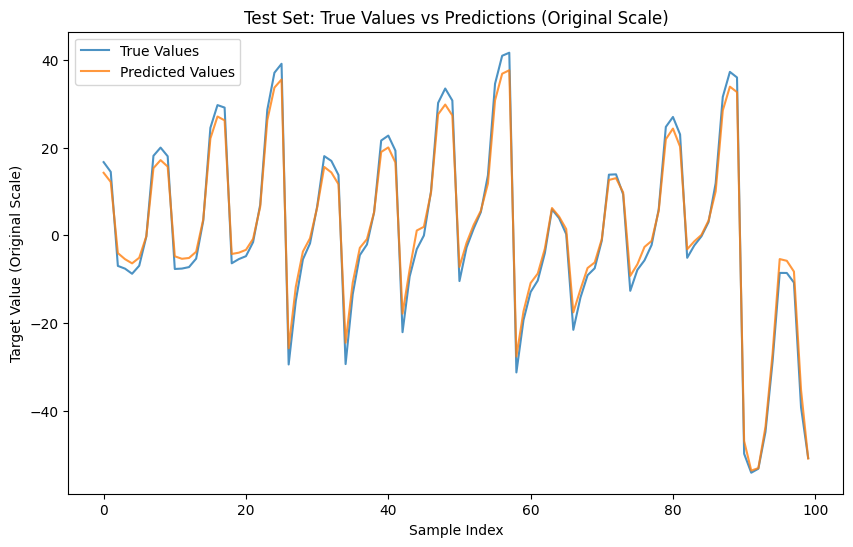

In [ ]:


# Charger les scalers pour normalisation et re-inverse
target_scaler = joblib.load('target_scaler.pkl')  # Scaler utilisé pour la cible

# Configuration de TimeSeriesSplit
n_splits = 10  # Nombre de divisions pour la validation croisée
tscv = TimeSeriesSplit(n_splits=n_splits)

# Liste pour stocker les scores des métriques
mse_scores = []
mae_scores = []
r2_scores = []
rmse_scores = []

# Liste pour les temps d'exécution
validation_times = []

# Parcours des splits de la validation croisée
split_num = 1
for train_idx, val_idx in tscv.split(X_train):
    print(f"\nProcessing Split {split_num}/{n_splits}")
    split_start = time()  # Démarrer le chronomètre pour ce split

    # Division des données en train et validation pour ce split
    X_train_split, X_val_split = X_train[train_idx], X_train[val_idx]
    y_train_split, y_val_split = y_train[train_idx], y_train[val_idx]

    # Définition du modèle  rnn
    model = Sequential()
    model.add(SimpleRNN(100, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(SimpleRNN(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))  # Couche de sortie

    # Compilation du modèle
    model.compile(optimizer='adam', loss='mse')

    # Entraînement du modèle
    history = model.fit(X_train_split, y_train_split,
                        epochs=20,
                        batch_size=64,
                        validation_data=(X_val_split, y_val_split),
                        verbose=0)

    # Prédictions sur le jeu de validation
    y_val_pred = model.predict(X_val_split)

    # Re-inverse pour ramener les prédictions et les valeurs réelles à l'échelle d'origine
    y_val_pred_original = target_scaler.inverse_transform(y_val_pred)
    y_val_original = target_scaler.inverse_transform(y_val_split)

    # Calcul des métriques sur l'échelle originale
    mse = mean_squared_error(y_val_original, y_val_pred_original)
    mae = mean_absolute_error(y_val_original, y_val_pred_original)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val_original, y_val_pred_original)

    # Stockage des scores
    mse_scores.append(mse)
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    r2_scores.append(r2)

    # Calcul du temps d'exécution pour ce split
    split_time = time() - split_start
    validation_times.append(split_time)
    print(f"Split {split_num - 1} Time: {int(split_time // 60)} min {int(split_time % 60)} sec")
    print(f"Split Metrics - MSE: {mse}, MAE: {mae}, RMSE: {rmse}, R²: {r2}")

# Moyennes des métriques sur tous les splits
print("\nCross-Validation Metrics (Original Scale):")
print(f"Average MSE: {np.mean(mse_scores)}")
print(f"Average MAE: {np.mean(mae_scores)}")
print(f"Average RMSE: {np.mean(rmse_scores)}")
print(f"Average R²: {np.mean(r2_scores)}")

# Temps total pour la validation croisée
total_validation_time = sum(validation_times)
print(f"\nTotal Validation Time: {int(total_validation_time // 60)} min {int(total_validation_time % 60)} sec")

model.save('rnn10-1.keras')


# Évaluation finale sur le jeu de test
print("\nTesting on the Test Set...")
test_start = time()  # Démarrer le chronomètre pour le test


# Prédictions sur le jeu de test
y_test_pred = model.predict(X_test)

# Re-inverse pour ramener les prédictions et les valeurs réelles à l'échelle d'origine
y_test_pred_original = target_scaler.inverse_transform(y_test_pred)
y_test_original = target_scaler.inverse_transform(y_test)

# Calcul des métriques sur l'échelle originale
mse_test = mean_squared_error(y_test_original, y_test_pred_original)
mae_test = mean_absolute_error(y_test_original, y_test_pred_original)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test_original, y_test_pred_original)

# Calcul du temps d'exécution pour le test
test_time = time() - test_start
print(f"\nTest Time: {int(test_time // 60)} min {int(test_time % 60)} sec")

# Affichage des métriques sur le jeu de test
print("\nTest Set Metrics (Original Scale):")
print(f"MSE: {mse_test}")
print(f"MAE: {mae_test}")
print(f"RMSE: {rmse_test}")
print(f"R²: {r2_test}")

# Visualisation des résultats sur le jeu de test
plt.figure(figsize=(10, 6))
plt.plot(y_test_original[:100], label="True Values", alpha=0.8)  # Afficher les 100 premières valeurs pour la lisibilité
plt.plot(y_test_pred_original[:100], label="Predicted Values", alpha=0.8)
plt.title("Test Set: True Values vs Predictions (Original Scale)")
plt.xlabel("Sample Index")
plt.ylabel("Target Value (Original Scale)")
plt.legend()
plt.show()


#xgboost

In [ ]:
# Convertir les données X_train et y_train en format compatible avec XGBoost
X_train_reshaped = X_train.squeeze()  # Enlever la dernière dimension inutilisée pour XGBoost
y_train_reshaped = y_train.squeeze()  # Enlever la dernière dimension inutilisée pour y_train

X_test_reshaped = X_test.squeeze()
y_test_reshaped = y_test.squeeze()

In [ ]:
from sklearn.model_selection import GridSearchCV


# Configuration de TimeSeriesSplit
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Définir la grille d’hyperparamètres
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 150, 200]
}

# Définir le modèle XGBoost
model = XGBRegressor(objective='reg:squarederror', random_state=42)

# Configuration de GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # Utiliser MSE comme métrique d’évaluation
    cv=tscv,
    verbose=2,
    n_jobs=-1
)

# Ajuster GridSearchCV sur les données d’entraînement
grid_search.fit(X_train_reshaped, y_train_reshaped)

# Résultats des meilleurs hyperparamètres
best_params = grid_search.best_params_
best_score = -grid_search.best_score_  # MSE (le score est retourné en négatif)

print("\nMeilleurs hyperparamètres trouvés par GridSearchCV:")
print(best_params)
print(f"Meilleur score (MSE): {best_score}")

# Résultats détaillés de GridSearchCV
cv_results = grid_search.cv_results_


Fitting 5 folds for each of 27 candidates, totalling 135 fits

Meilleurs hyperparamètres trouvés par GridSearchCV:
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Meilleur score (MSE): 8.418216998579889e-07



Processing Split 1/5
Split 1 Time: 0 min 0 sec
Split Metrics - MSE: 0.8111253929753514, MAE: 0.6469456757053808, RMSE: 0.9006250013048446, R²: 0.9989879185237498

Processing Split 2/5
Split 2 Time: 0 min 0 sec
Split Metrics - MSE: 0.9557441773170685, MAE: 0.5572676903778566, RMSE: 0.9776216943772619, R²: 0.9991532530312982

Processing Split 3/5
Split 3 Time: 0 min 0 sec
Split Metrics - MSE: 0.5685415475440306, MAE: 0.49738902981172345, RMSE: 0.7540169411518753, R²: 0.9979002284956031

Processing Split 4/5
Split 4 Time: 0 min 0 sec
Split Metrics - MSE: 0.5371264732863953, MAE: 0.4433011548801466, RMSE: 0.7328891275536807, R²: 0.9993375224725249

Processing Split 5/5
Split 5 Time: 0 min 0 sec
Split Metrics - MSE: 0.7502847361438524, MAE: 0.45627647285001094, RMSE: 0.8661897806738731, R²: 0.9992306890329806

Cross-Validation Metrics (Original Scale):
Average MSE: 0.7245644654533396
Average MAE: 0.5202360047250236
Average RMSE: 0.8462685090123072
Average R²: 0.9989219223112313

Total Vali

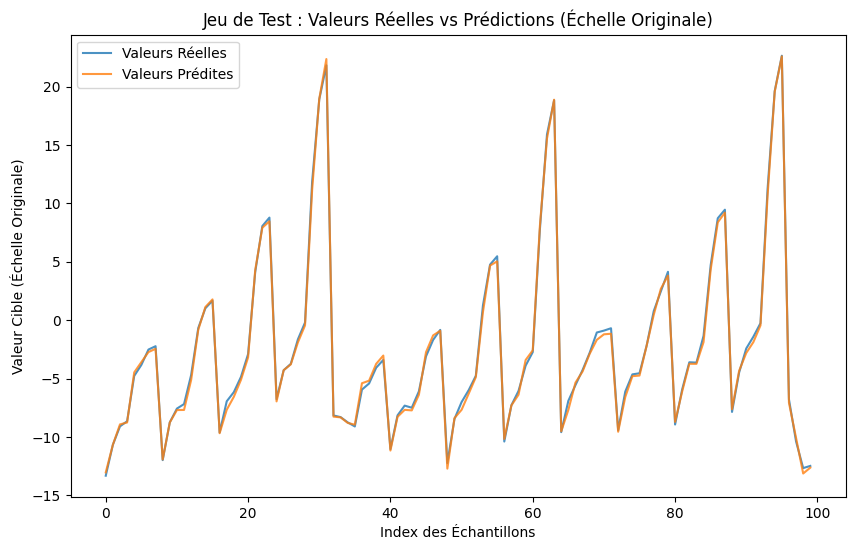

In [ ]:
import time
# Configuration de TimeSeriesSplit
n_splits = 5  # Nombre de divisions pour la validation croisée
tscv = TimeSeriesSplit(n_splits=n_splits)

# Liste pour stocker les scores des métriques
mse_scores = []
mae_scores = []
r2_scores = []
rmse_scores = []

# Mesure des temps pour la validation croisée
validation_times = []


split_num = 1
for train_idx, val_idx in tscv.split(X_train_reshaped):
    print(f"\nProcessing Split {split_num}/{n_splits}")
    split_start_time = time.time()  # Démarrer le chronomètre pour ce split

    # Division des données en train et validation pour ce split
    X_train_split, X_val_split = X_train_reshaped[train_idx], X_train_reshaped[val_idx]
    y_train_split, y_val_split = y_train_reshaped[train_idx], y_train_reshaped[val_idx]

    # Définition du modèle XGBoost Regressor
    model = XGBRegressor(
        learning_rate=0.1,
        max_depth=5,
        n_estimators=200,
        objective='reg:squarederror'
    )

    # Entraînement du modèle
    model.fit(X_train_split, y_train_split)

    # Prédictions sur le jeu de validation
    y_val_pred = model.predict(X_val_split)

    # Re-inverse pour ramener les prédictions et les valeurs réelles à l'échelle d'origine
    y_val_pred_original = target_scaler.inverse_transform(y_val_pred.reshape(-1, 1))
    y_val_original = target_scaler.inverse_transform(y_val_split.reshape(-1, 1))

    # Calcul des métriques sur l'échelle originale
    mse = mean_squared_error(y_val_original, y_val_pred_original)
    mae = mean_absolute_error(y_val_original, y_val_pred_original)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val_original, y_val_pred_original)

    # Stockage des scores
    mse_scores.append(mse)
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    r2_scores.append(r2)

    # Calcul du temps pour ce split
    split_time = time.time() - split_start_time
    validation_times.append(split_time)
    print(f"Split {split_num} Time: {int(split_time // 60)} min {int(split_time % 60)} sec")
    print(f"Split Metrics - MSE: {mse}, MAE: {mae}, RMSE: {rmse}, R²: {r2}")

    split_num += 1

# Moyennes des métriques sur tous les splits
print("\nCross-Validation Metrics (Original Scale):")
print(f"Average MSE: {np.mean(mse_scores)}")
print(f"Average MAE: {np.mean(mae_scores)}")
print(f"Average RMSE: {np.mean(rmse_scores)}")
print(f"Average R²: {np.mean(r2_scores)}")

# Temps total pour la validation croisée
total_validation_time = sum(validation_times)
print(f"\nTotal Validation Time: {int(total_validation_time // 60)} min {int(total_validation_time % 60)} sec")

# Évaluation finale sur le jeu de test
print("\nTesting on the Test Set...")
test_start_time = time.time()  # Démarrer le chronomètre pour le test


# Prédictions sur le jeu de test
y_test_pred = model.predict(X_test_reshaped)
model.save_model('xgboost_model_5.json')

# Re-inverse pour ramener les prédictions et les valeurs réelles à l'échelle d'origine
y_test_pred_original = target_scaler.inverse_transform(y_test_pred.reshape(-1, 1))
y_test_original = target_scaler.inverse_transform(y_test_reshaped.reshape(-1, 1))

# Calcul des métriques sur le jeu de test
mse_test = mean_squared_error(y_test_original, y_test_pred_original)
mae_test = mean_absolute_error(y_test_original, y_test_pred_original)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test_original, y_test_pred_original)

# Calcul du temps pour le test
test_time = time.time() - test_start_time
print(f"\nTest Time: {int(test_time // 60)} min {int(test_time % 60)} sec")

# Affichage des métriques sur le jeu de test
print("\nTest Set Metrics (Original Scale):")
print(f"MSE: {mse_test}")
print(f"MAE: {mae_test}")
print(f"RMSE: {rmse_test}")
print(f"R²: {r2_test}")
# Visualisation des résultats sur le jeu de test
plt.figure(figsize=(10, 6))
plt.plot(y_test_original[:100], label="Valeurs Réelles", alpha=0.8)  # Les 100 premières valeurs pour plus de clarté
plt.plot(y_test_pred_original[:100], label="Valeurs Prédites", alpha=0.8)
plt.title("Jeu de Test : Valeurs Réelles vs Prédictions (Échelle Originale)")
plt.xlabel("Index des Échantillons")
plt.ylabel("Valeur Cible (Échelle Originale)")
plt.legend()
plt.show()


In [ ]:
from sklearn.model_selection import GridSearchCV


# Configuration de TimeSeriesSplit
n_splits = 7
tscv = TimeSeriesSplit(n_splits=n_splits)

# Définir la grille d’hyperparamètres
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 150, 200]
}

# Définir le modèle XGBoost
model = XGBRegressor(objective='reg:squarederror', random_state=42)

# Configuration de GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # Utiliser MSE comme métrique d’évaluation
    cv=tscv,
    verbose=2,
    n_jobs=-1
)

# Ajuster GridSearchCV sur les données d’entraînement
grid_search.fit(X_train_reshaped, y_train_reshaped)

# Résultats des meilleurs hyperparamètres
best_params = grid_search.best_params_
best_score = -grid_search.best_score_  # MSE (le score est retourné en négatif)

print("\nMeilleurs hyperparamètres trouvés par GridSearchCV:")
print(best_params)
print(f"Meilleur score (MSE): {best_score}")

# Résultats détaillés de GridSearchCV
cv_results = grid_search.cv_results_


Fitting 7 folds for each of 27 candidates, totalling 189 fits

Meilleurs hyperparamètres trouvés par GridSearchCV:
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Meilleur score (MSE): 2.325297660864371e-06



Processing Split 1/7
Split 1 Time: 0 min 0 sec
Split Metrics - MSE: 10.053587925532039, MAE: 2.160934925059127, RMSE: 3.1707393342140313, R²: 0.982064496367642

Processing Split 2/7
Split 2 Time: 0 min 0 sec
Split Metrics - MSE: 0.6317278099523277, MAE: 0.5626052156772916, RMSE: 0.794813066042782, R²: 0.9918334839239499

Processing Split 3/7
Split 3 Time: 0 min 0 sec
Split Metrics - MSE: 0.9734281213255492, MAE: 0.5468934221348467, RMSE: 0.9866246101357645, R²: 0.9985050996985289

Processing Split 4/7
Split 4 Time: 0 min 0 sec
Split Metrics - MSE: 0.3896343917338349, MAE: 0.4540450066593156, RMSE: 0.624207010320963, R²: 0.9977585097075424

Processing Split 5/7
Split 5 Time: 0 min 0 sec
Split Metrics - MSE: 0.8124340498474053, MAE: 0.5267741668245143, RMSE: 0.9013512355610355, R²: 0.9990854688764522

Processing Split 6/7
Split 6 Time: 0 min 2 sec
Split Metrics - MSE: 0.3115337371279917, MAE: 0.41857107884523626, RMSE: 0.5581520734781801, R²: 0.9987070182321182

Processing Split 7/7
Spl

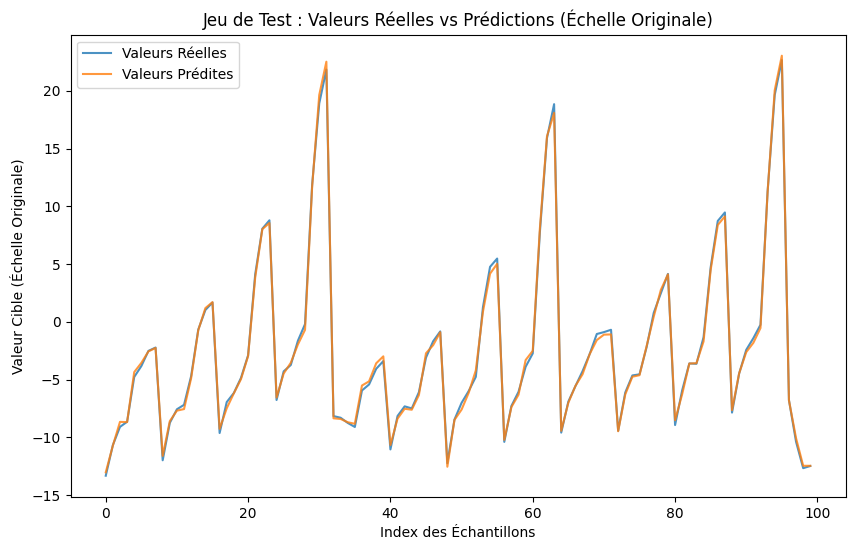

In [ ]:


# Configuration de TimeSeriesSplit
n_splits = 7  # Nombre de divisions pour la validation croisée
tscv = TimeSeriesSplit(n_splits=n_splits)

# Liste pour stocker les scores des métriques
mse_scores = []
mae_scores = []
r2_scores = []
rmse_scores = []

# Mesure des temps pour la validation croisée
validation_times = []

# Convertir les données X_train et y_train en format compatible avec XGBoost
X_train_reshaped = X_train.squeeze()  # Enlever la dernière dimension inutilisée pour XGBoost
y_train_reshaped = y_train.squeeze()  # Enlever la dernière dimension inutilisée pour y_train

split_num = 1
for train_idx, val_idx in tscv.split(X_train_reshaped):
    print(f"\nProcessing Split {split_num}/{n_splits}")
    split_start_time = time.time()  # Démarrer le chronomètre pour ce split

    # Division des données en train et validation pour ce split
    X_train_split, X_val_split = X_train_reshaped[train_idx], X_train_reshaped[val_idx]
    y_train_split, y_val_split = y_train_reshaped[train_idx], y_train_reshaped[val_idx]

    # Définition du modèle XGBoost Regressor
    model = XGBRegressor(
        learning_rate=0.1,
        max_depth=5,
        n_estimators=200,
        objective='reg:squarederror'
    )

    # Entraînement du modèle
    model.fit(X_train_split, y_train_split)

    # Prédictions sur le jeu de validation
    y_val_pred = model.predict(X_val_split)

    # Re-inverse pour ramener les prédictions et les valeurs réelles à l'échelle d'origine
    y_val_pred_original = target_scaler.inverse_transform(y_val_pred.reshape(-1, 1))
    y_val_original = target_scaler.inverse_transform(y_val_split.reshape(-1, 1))

    # Calcul des métriques sur l'échelle originale
    mse = mean_squared_error(y_val_original, y_val_pred_original)
    mae = mean_absolute_error(y_val_original, y_val_pred_original)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val_original, y_val_pred_original)

    # Stockage des scores
    mse_scores.append(mse)
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    r2_scores.append(r2)

    # Calcul du temps pour ce split
    split_time = time.time() - split_start_time
    validation_times.append(split_time)
    print(f"Split {split_num} Time: {int(split_time // 60)} min {int(split_time % 60)} sec")
    print(f"Split Metrics - MSE: {mse}, MAE: {mae}, RMSE: {rmse}, R²: {r2}")

    split_num += 1

# Moyennes des métriques sur tous les splits
print("\nCross-Validation Metrics (Original Scale):")
print(f"Average MSE: {np.mean(mse_scores)}")
print(f"Average MAE: {np.mean(mae_scores)}")
print(f"Average RMSE: {np.mean(rmse_scores)}")
print(f"Average R²: {np.mean(r2_scores)}")

# Temps total pour la validation croisée
total_validation_time = sum(validation_times)
print(f"\nTotal Validation Time: {int(total_validation_time // 60)} min {int(total_validation_time % 60)} sec")

# Évaluation finale sur le jeu de test
print("\nTesting on the Test Set...")
test_start_time = time.time()  # Démarrer le chronomètre pour le test

# Suppression de la troisième dimension dans X_test et y_test si nécessaire
X_test_reshaped = X_test.squeeze()
y_test_reshaped = y_test.squeeze()

# Prédictions sur le jeu de test
y_test_pred = model.predict(X_test_reshaped)
model.save_model('xgboost_model7.json')

# Re-inverse pour ramener les prédictions et les valeurs réelles à l'échelle d'origine
y_test_pred_original = target_scaler.inverse_transform(y_test_pred.reshape(-1, 1))
y_test_original = target_scaler.inverse_transform(y_test_reshaped.reshape(-1, 1))

# Calcul des métriques sur le jeu de test
mse_test = mean_squared_error(y_test_original, y_test_pred_original)
mae_test = mean_absolute_error(y_test_original, y_test_pred_original)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test_original, y_test_pred_original)

# Calcul du temps pour le test
test_time = time.time() - test_start_time
print(f"\nTest Time: {int(test_time // 60)} min {int(test_time % 60)} sec")

# Affichage des métriques sur le jeu de test
print("\nTest Set Metrics (Original Scale):")
print(f"MSE: {mse_test}")
print(f"MAE: {mae_test}")
print(f"RMSE: {rmse_test}")
print(f"R²: {r2_test}")
# Visualisation des résultats sur le jeu de test
plt.figure(figsize=(10, 6))
plt.plot(y_test_original[:100], label="Valeurs Réelles", alpha=0.8)  # Les 100 premières valeurs pour plus de clarté
plt.plot(y_test_pred_original[:100], label="Valeurs Prédites", alpha=0.8)
plt.title("Jeu de Test : Valeurs Réelles vs Prédictions (Échelle Originale)")
plt.xlabel("Index des Échantillons")
plt.ylabel("Valeur Cible (Échelle Originale)")
plt.legend()
plt.show()


In [ ]:
from sklearn.model_selection import GridSearchCV


# Configuration de TimeSeriesSplit
n_splits = 10
tscv = TimeSeriesSplit(n_splits=n_splits)

# Définir la grille d’hyperparamètres
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 150, 200]
}

# Définir le modèle XGBoost
model = XGBRegressor(objective='reg:squarederror', random_state=42)

# Configuration de GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # Utiliser MSE comme métrique d’évaluation
    cv=tscv,
    verbose=2,
    n_jobs=-1
)

# Ajuster GridSearchCV sur les données d’entraînement
grid_search.fit(X_train_reshaped, y_train_reshaped)

# Résultats des meilleurs hyperparamètres
best_params = grid_search.best_params_
best_score = -grid_search.best_score_  # MSE (le score est retourné en négatif)

print("\nMeilleurs hyperparamètres trouvés par GridSearchCV:")
print(best_params)
print(f"Meilleur score (MSE): {best_score}")

# Résultats détaillés de GridSearchCV
cv_results = grid_search.cv_results_


Fitting 10 folds for each of 27 candidates, totalling 270 fits

Meilleurs hyperparamètres trouvés par GridSearchCV:
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Meilleur score (MSE): 5.2946917231181596e-05



Processing Split 1/10
Split 1 Time: 0 min 0 sec
Split Metrics - MSE: 443.8817001297006, MAE: 17.018577189930124, RMSE: 21.068500187001938, R²: 0.4473776691822996

Processing Split 2/10
Split 2 Time: 0 min 0 sec
Split Metrics - MSE: 1.4086514647606176, MAE: 0.9196860193439034, RMSE: 1.1868662370969265, R²: 0.9972053014614313

Processing Split 3/10
Split 3 Time: 0 min 0 sec
Split Metrics - MSE: 0.8883661999771064, MAE: 0.6524787482189628, RMSE: 0.9425318031648091, R²: 0.9853199968943631

Processing Split 4/10
Split 4 Time: 0 min 0 sec
Split Metrics - MSE: 2.39468434676903, MAE: 0.9188273612655347, RMSE: 1.5474767677639074, R²: 0.9978204840818237

Processing Split 5/10
Split 5 Time: 0 min 1 sec
Split Metrics - MSE: 0.5208103645707978, MAE: 0.5700657996979571, RMSE: 0.7216719230861055, R²: 0.9985648570423804

Processing Split 6/10
Split 6 Time: 0 min 0 sec
Split Metrics - MSE: 0.8355266583460281, MAE: 0.6101584848818856, RMSE: 0.914071473324722, R²: 0.9846623320334914

Processing Split 7/

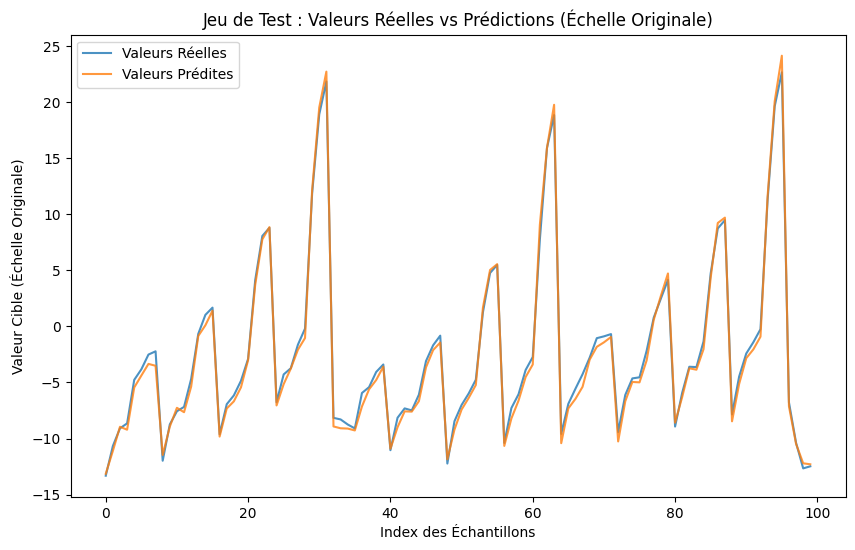

In [ ]:


# Configuration de TimeSeriesSplit
n_splits = 10  # Nombre de divisions pour la validation croisée
tscv = TimeSeriesSplit(n_splits=n_splits)

# Liste pour stocker les scores des métriques
mse_scores = []
mae_scores = []
r2_scores = []
rmse_scores = []

# Mesure des temps pour la validation croisée
validation_times = []

# Convertir les données X_train et y_train en format compatible avec XGBoost
X_train_reshaped = X_train.squeeze()  # Enlever la dernière dimension inutilisée pour XGBoost
y_train_reshaped = y_train.squeeze()  # Enlever la dernière dimension inutilisée pour y_train

split_num = 1
for train_idx, val_idx in tscv.split(X_train_reshaped):
    print(f"\nProcessing Split {split_num}/{n_splits}")
    split_start_time = time.time()  # Démarrer le chronomètre pour ce split

    # Division des données en train et validation pour ce split
    X_train_split, X_val_split = X_train_reshaped[train_idx], X_train_reshaped[val_idx]
    y_train_split, y_val_split = y_train_reshaped[train_idx], y_train_reshaped[val_idx]

    # Définition du modèle XGBoost Regressor
    model = XGBRegressor(
        learning_rate=0.1,
        max_depth=3,
        n_estimators=200,
        objective='reg:squarederror'
    )

    # Entraînement du modèle
    model.fit(X_train_split, y_train_split)

    # Prédictions sur le jeu de validation
    y_val_pred = model.predict(X_val_split)

    # Re-inverse pour ramener les prédictions et les valeurs réelles à l'échelle d'origine
    y_val_pred_original = target_scaler.inverse_transform(y_val_pred.reshape(-1, 1))
    y_val_original = target_scaler.inverse_transform(y_val_split.reshape(-1, 1))

    # Calcul des métriques sur l'échelle originale
    mse = mean_squared_error(y_val_original, y_val_pred_original)
    mae = mean_absolute_error(y_val_original, y_val_pred_original)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val_original, y_val_pred_original)

    # Stockage des scores
    mse_scores.append(mse)
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    r2_scores.append(r2)

    # Calcul du temps pour ce split
    split_time = time.time() - split_start_time
    validation_times.append(split_time)
    print(f"Split {split_num} Time: {int(split_time // 60)} min {int(split_time % 60)} sec")
    print(f"Split Metrics - MSE: {mse}, MAE: {mae}, RMSE: {rmse}, R²: {r2}")

    split_num += 1

# Moyennes des métriques sur tous les splits
print("\nCross-Validation Metrics (Original Scale):")
print(f"Average MSE: {np.mean(mse_scores)}")
print(f"Average MAE: {np.mean(mae_scores)}")
print(f"Average RMSE: {np.mean(rmse_scores)}")
print(f"Average R²: {np.mean(r2_scores)}")

# Temps total pour la validation croisée
total_validation_time = sum(validation_times)
print(f"\nTotal Validation Time: {int(total_validation_time // 60)} min {int(total_validation_time % 60)} sec")

# Évaluation finale sur le jeu de test
print("\nTesting on the Test Set...")
test_start_time = time.time()  # Démarrer le chronomètre pour le test

# Suppression de la troisième dimension dans X_test et y_test si nécessaire
X_test_reshaped = X_test.squeeze()
y_test_reshaped = y_test.squeeze()

# Prédictions sur le jeu de test
y_test_pred = model.predict(X_test_reshaped)
model.save_model('xgboost-10-1.json')

# Re-inverse pour ramener les prédictions et les valeurs réelles à l'échelle d'origine
y_test_pred_original = target_scaler.inverse_transform(y_test_pred.reshape(-1, 1))
y_test_original = target_scaler.inverse_transform(y_test_reshaped.reshape(-1, 1))

# Calcul des métriques sur le jeu de test
mse_test = mean_squared_error(y_test_original, y_test_pred_original)
mae_test = mean_absolute_error(y_test_original, y_test_pred_original)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test_original, y_test_pred_original)

# Calcul du temps pour le test
test_time = time.time() - test_start_time
print(f"\nTest Time: {int(test_time // 60)} min {int(test_time % 60)} sec")

# Affichage des métriques sur le jeu de test
print("\nTest Set Metrics (Original Scale):")
print(f"MSE: {mse_test}")
print(f"MAE: {mae_test}")
print(f"RMSE: {rmse_test}")
print(f"R²: {r2_test}")
# Visualisation des résultats sur le jeu de test
plt.figure(figsize=(10, 6))
plt.plot(y_test_original[:100], label="Valeurs Réelles", alpha=0.8)  # Les 100 premières valeurs pour plus de clarté
plt.plot(y_test_pred_original[:100], label="Valeurs Prédites", alpha=0.8)
plt.title("Jeu de Test : Valeurs Réelles vs Prédictions (Échelle Originale)")
plt.xlabel("Index des Échantillons")
plt.ylabel("Valeur Cible (Échelle Originale)")
plt.legend()
plt.show()


#Deploiement

In [ ]:
!pip install gradio

In [ ]:
# Liste des modèles et leurs scalers associés
models_info = [
    {
        "name": "Bidirectional LSTM",
        "model_path": "bi-lstm5-1.keras",
        "feature_scaler_path": "feature_scaler.pkl",
        "target_scaler_path": "target_scaler.pkl",
    },
    {
        "name": "LSTM",
        "model_path": "lstm5-1.keras",
        "feature_scaler_path": "feature_scaler.pkl",
        "target_scaler_path": "target_scaler.pkl",
    },
    {
        "name": "RNN",
        "model_path": "rnn5-1.keras",
        "feature_scaler_path": "feature_scaler.pkl",
        "target_scaler_path": "target_scaler.pkl",
    },
    {
        "name": "GRU",
        "model_path": "gru7-1.keras",
        "feature_scaler_path": "feature_scaler.pkl",
        "target_scaler_path": "target_scaler.pkl",
    },
    {
        "name": "XGBoost Regressor",
        "model_path": "xgboost_model_1_5.json",
        "feature_scaler_path": "feature_scaler.pkl",
        "target_scaler_path": "target_scaler.pkl",
        "type": "xgboost"
    },
]
feature_columns = ['LAT', 'LON', 'YEAR', 'DOY', 'T2M', 'T2MDEW', 'T2M_MAX', 'T2M_MIN',
                   'ALLSKY_SFC_SW_DWN', 'ALLSKY_SFC_LW_DWN', 'PS', 'WS2M', 'PRECTOTCORR',
                   'GWETROOT', 'Month', 'Saison_Saison_pluies', 'Saison_Saison_seche']


# Fonction pour charger un modèle
def load_model_and_scalers(model_info):
    try:
        if model_info.get("type") == "xgboost":
            from xgboost import XGBRegressor
            model = XGBRegressor()
            model.load_model(model_info["model_path"])
        else:
            model = load_model(model_info["model_path"])  # Pour Keras modèles

        feature_scaler = joblib.load(model_info["feature_scaler_path"])
        target_scaler = joblib.load(model_info["target_scaler_path"])
        return model, feature_scaler, target_scaler
    except Exception as e:
        print(f"Error while loading model or scalers for {model_info['name']}: {e}")
        raise

# Fonction pour effectuer une prédiction avec un modèle
def predict_with_model(model, feature_scaler, target_scaler, input_data, model_type="keras"):
    try:
        # Préparer les données utilisateur
        user_data = pd.DataFrame([input_data], columns=feature_columns)

        # Normaliser les données utilisateur
        user_data_normalized = feature_scaler.transform(user_data)

        # Prévoir avec le modèle
        if model_type == "xgboost":
            prediction_normalized = model.predict(user_data_normalized)
        else:
            user_data_reshaped = user_data_normalized.reshape((1, user_data_normalized.shape[1], 1))
            prediction_normalized = model.predict(user_data_reshaped)

        # Inverser la normalisation de la prédiction
        prediction_original = target_scaler.inverse_transform(prediction_normalized.reshape(-1, 1))
        return float(prediction_original[0][0])
    except Exception as e:
        print(f"Error during prediction with model: {e}")
        raise

# Fonction Gradio pour afficher les prédictions de plusieurs modèles
def predict_and_evaluate_multi(lat, lon, year, doy, t2m, t2mdew, t2m_max, t2m_min,
                                sw_dwn, lw_dwn, ps, ws2m, prectot, gwetroot, month,
                                saison_pluies, saison_seche):
    try:
        # Entrée utilisateur
        input_data = [
            lat, lon, year, doy, t2m, t2mdew, t2m_max, t2m_min,
            sw_dwn, lw_dwn, ps, ws2m, prectot, gwetroot, month,
            saison_pluies, saison_seche
        ]

        # Stocker les résultats
        results = {}

        for model_info in models_info:
            try:
                model, feature_scaler, target_scaler = load_model_and_scalers(model_info)
                model_type = model_info.get("type", "keras")

                # Prédiction
                prediction = predict_with_model(
                    model, feature_scaler, target_scaler, input_data, model_type
                )

                # Ajouter les résultats
                results[model_info["name"]] = {
                    "Prediction (IRR, Original Scale)": prediction,
                }
            except Exception as e:
                results[model_info["name"]] = {"error": str(e)}

        return results
    except Exception as e:
        print(f"Error in predict_and_evaluate_multi function: {e}")
        raise

# Interface utilisateur Gradio
inputs = [
    gr.Number(label="LAT"), gr.Number(label="LON"), gr.Number(label="YEAR"),
    gr.Number(label="DOY"), gr.Number(label="T2M"), gr.Number(label="T2MDEW"),
    gr.Number(label="T2M_MAX"), gr.Number(label="T2M_MIN"),
    gr.Number(label="ALLSKY_SFC_SW_DWN"), gr.Number(label="ALLSKY_SFC_LW_DWN"),
    gr.Number(label="PS"), gr.Number(label="WS2M"), gr.Number(label="PRECTOTCORR"),
    gr.Number(label="GWETROOT"), gr.Number(label="Month"),
    gr.Number(label="Saison_Saison_pluies"), gr.Number(label="Saison_Saison_seche"),
]

outputs = gr.JSON(label="Results")

# Lancer Gradio
gr.Interface(
    fn=predict_and_evaluate_multi,
    inputs=inputs,
    outputs=outputs,
    title="Multi-Model Prediction",
    description="Entrez les valeurs des features pour obtenir les prédictions IRR avec plusieurs modèles.",
).launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://9a06a4d0d6849b6a7a.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
import pandas as pd

# Creating the dataset based on the given data
data = {
    "LAT": [10.25],
    "LON": [-13.25],
    "YEAR": [2024],
    "DOY": [275],
    "ALLSKY_SFC_SW_DWN": [20.5],
    "ALLSKY_SFC_LW_DWN": [428.87],
    "T2M": [25.51],
    "T2MDEW": [23.71],
    "T2M_MAX": [29.24],
    "T2M_MIN": [22.61],
    "PRECTOTCORR": [8.57],
    "PS": [97.82],
    "WS2M": [1.49],
    "GWETROOT": [0]
}

d = pd.DataFrame(data)


In [ ]:
irr(d)

,LAT,LON,YEAR,DOY,ALLSKY_SFC_SW_DWN,ALLSKY_SFC_LW_DWN,T2M,T2MDEW,T2M_MAX,T2M_MIN,PRECTOTCORR,PS,WS2M,GWETROOT,IRR
0,10.25,-13.25,2024,275,20.5,428.87,25.51,23.71,29.24,22.61,8.57,97.82,1.49,0,104.053796


In [ ]:
data

,LAT,LON,YEAR,DOY,T2M,ALLSKY_SFC_SW_DWN,ALLSKY_SFC_LW_DWN,T2MDEW,T2M_MAX,T2M_MIN,PS,WS2M,PRECTOTCORR,GWETROOT,IRR
0,10.25,-13.25,2024,275,20.5,428.87,25.51,23.71,29.24,22.61,97.82,1.49,0,8.57,845.717319


In [ ]:
# Adding the new row of data based on the provided information
new_data = {
    "LAT": [10.25],
    "LON": [-12.75],
    "YEAR": [2024],
    "DOY": [275],
    "ALLSKY_SFC_SW_DWN": [18.08],
    "ALLSKY_SFC_LW_DWN": [420.48],
    "T2M": [25.3],
    "T2MDEW": [23.32],
    "T2M_MAX": [29.18],
    "T2M_MIN": [22.09],
    "PRECTOTCORR": [5.19],
    "PS": [97.0],
    "WS2M": [1.42],
    "GWETROOT": [0]
}

d1 = pd.DataFrame(new_data)


In [ ]:
d1

,LAT,LON,YEAR,DOY,ALLSKY_SFC_SW_DWN,ALLSKY_SFC_LW_DWN,T2M,T2MDEW,T2M_MAX,T2M_MIN,PRECTOTCORR,PS,WS2M,GWETROOT
0,10.25,-12.75,2024,275,18.08,420.48,25.3,23.32,29.18,22.09,5.19,97.0,1.42,0


In [ ]:
irr(d1)

,LAT,LON,YEAR,DOY,ALLSKY_SFC_SW_DWN,ALLSKY_SFC_LW_DWN,T2M,T2MDEW,T2M_MAX,T2M_MIN,PRECTOTCORR,PS,WS2M,GWETROOT,IRR
0,10.25,-12.75,2024,275,18.08,420.48,25.3,23.32,29.18,22.09,5.19,97.0,1.42,0,106.198352
